In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings
import re
import os
import time
import datetime
import statsmodels.api as sm
from os import listdir
from os.path import isfile, join
# Ignore all warnings
warnings.filterwarnings("ignore")


In [3]:
raw_path = '/Users/sofiaperelli-rocco/Desktop/UK_EoH_2020-2022/'
all_performance_df = pd.read_csv(raw_path + "heat_pump_performance_summary_v1-0.csv") 
properties_path = os.path.join(raw_path, '9050_csv_united_cleansed_data/')
properties_names = [f for f in listdir(properties_path) if isfile(join(properties_path, f))]
csv_file_path_info = "BEIS Electrification of Heat Project - Property, Design and Installation Information.csv"
properties_info_df = pd.read_csv(raw_path + csv_file_path_info)


In [4]:
columns_to_diff = ['Circulation_Pump_Energy_Consumed', 'Heat_Pump_Energy_Output','Boiler_Energy_Output',
                   'Immersion_Heater_Energy_Consumed', 'Whole_System_Energy_Consumed', 'Back-up_Heater_Energy_Consumed', 'HP_Consumption']
columns_to_mean = ['delta_Circulation_Pump_Energy_Consumed', 'External_Air_Temperature', 'delta_Heat_Pump_Energy_Output',
                   'Heat_Pump_Heating_Flow_Temperature', 'Heat_Pump_Return_Temperature', 'Hot_Water_Flow_Temperature',
                   'delta_Immersion_Heater_Energy_Consumed', 'Internal_Air_Temperature', 'delta_Whole_System_Energy_Consumed',
                  'delta_Boiler_Energy_Output', 'delta_Back-up_Heater_Energy_Consumed', 'delta_HP_Consumption'] 
keys_to_subtract_for_HP_energy= ['Back-up_Heater_Energy_Consumed', 'Immersion_Heater_Energy_Consumed', 'Circulation_Pump_Energy_Consumed']
columns_SPFn = ['Circulation_Pump_Energy_Consumed', 'Immersion_Heater_Energy_Consumed', 'Back-up_Heater_Energy_Consumed', 'HP_Consumption', 'Heat_Pump_Energy_Output']
columns_SPFn_inst = ['delta_Circulation_Pump_Energy_Consumed', 'delta_Immersion_Heater_Energy_Consumed', 'delta_Back-up_Heater_Energy_Consumed', 'delta_HP_Consumption', 'delta_Heat_Pump_Energy_Output']


In [5]:
def fill_cumulative_data(df):
    """
    Input: the dataframe containing row data with the metered house readings
    Function: This function gets the row dataframe and, if the cumulative energy consumption value of the last row  
    containing data and the nex one where the data is filled again is unchanged, it fills the blank spaces with the 
    cumulative value that should have been there but that was not uploaded.
    Output: the original row dataframe with filled blank data'''
    """
    col_fill = [col for col in columns_to_diff if col != 'HP_Consumption'] + ['House_SAP']
    #col_fill = [col for col in columns_to_diff if col != 'HP_Consumption' and col == 'House_SAP']
    #col_fill = [col for col in columns_to_diff and col == 'House_SAP' if col != 'HP_Consumption']
    df_copy = df.copy()

    for col in col_fill:
        if col not in df_copy:
            df_copy[col] = np.nan

    for col in col_fill:
        forward_filled = df_copy[col].ffill()
        backward_filled = df_copy[col].bfill()
        match_mask = (forward_filled == backward_filled)
        df_copy[col] = df_copy[col].mask(match_mask, forward_filled)

    for key in df_copy.keys():
        if key not in df.keys():
            df_copy.drop(key, axis=1, inplace=True)
    return(df_copy)

In [6]:
def get_avg_SPFn(df):
    window_df_copy = df.copy()
    
    for column in columns_SPFn:
        if column not in window_df_copy.columns:
            window_df_copy[column] = 0
    
    # Create a new df that contains only raws that have all non nan values
    valid_rows = window_df_copy.loc[(~window_df_copy['Heat_Pump_Energy_Output'].isnull()) &
                                    (~window_df_copy['HP_Consumption'].isnull()) &
                                    (~window_df_copy['Immersion_Heater_Energy_Consumed'].isnull()) &
                                    (~window_df_copy['Back-up_Heater_Energy_Consumed'].isnull()) &
                                    (~window_df_copy['Circulation_Pump_Energy_Consumed'].isnull())]

    if len(valid_rows) == 0:
        return float('nan'), float('nan'), float('nan')
    
    # Retrive the first of the rows with filled non nan data and the last one (of the window_df)
    first_valid_row = valid_rows.iloc[0]
    last_valid_row = valid_rows.iloc[-1]

    initial_Heat_Pump_Energy_Output = first_valid_row['Heat_Pump_Energy_Output']
    final_Heat_Pump_Energy_Output = last_valid_row['Heat_Pump_Energy_Output']
    initial_HP_Consumption = first_valid_row['HP_Consumption']
    final_HP_Consumption = last_valid_row['HP_Consumption']
    initial_Immersion_Heater_Energy_Consumed = first_valid_row['Immersion_Heater_Energy_Consumed']
    final_Immersion_Heater_Energy_Consumed = last_valid_row['Immersion_Heater_Energy_Consumed']
    initial_Circulation_Pump_Energy_Consumed = first_valid_row['Circulation_Pump_Energy_Consumed']
    final_Circulation_Pump_Energy_Consumed = last_valid_row['Circulation_Pump_Energy_Consumed']
    initial_Back_up_Heater_Energy_Consumed = first_valid_row['Back-up_Heater_Energy_Consumed']
    final_Back_up_Heater_Energy_Consumed = last_valid_row['Back-up_Heater_Energy_Consumed']

    avg_SPFH2 = (final_Heat_Pump_Energy_Output - initial_Heat_Pump_Energy_Output) / (
                final_HP_Consumption - initial_HP_Consumption) if (
                final_HP_Consumption - initial_HP_Consumption) != 0 else float('nan')
    avg_SPFH3 = (final_Heat_Pump_Energy_Output - initial_Heat_Pump_Energy_Output) / (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed)) if (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed)) != 0 else float('nan')
    avg_SPFH4 = (final_Heat_Pump_Energy_Output - initial_Heat_Pump_Energy_Output) / (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed) +
                (final_Circulation_Pump_Energy_Consumed - initial_Circulation_Pump_Energy_Consumed)) if (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed) +
                (final_Circulation_Pump_Energy_Consumed - initial_Circulation_Pump_Energy_Consumed)) != 0 else float('nan')

    return avg_SPFH2, avg_SPFH3, avg_SPFH4


In [7]:
def get_inst_SPFHn(df):
    df_copy = df.copy()
    
    for column in columns_SPFn_inst: 
        if column not in df_copy.columns:
            df_copy[column] = 0
            
    df['SPFH2_instantaneous'] = np.where( (df_copy['delta_HP_Consumption'] > 0),
                                         df_copy['delta_Heat_Pump_Energy_Output'] / df_copy['delta_HP_Consumption'], np.nan) 
    
    df['SPFH3_instantaneous'] = np.where( (df_copy['delta_HP_Consumption'] > 0), 
                                         df_copy['delta_Heat_Pump_Energy_Output'] / (df_copy['delta_HP_Consumption'] + df_copy['delta_Immersion_Heater_Energy_Consumed'] + df_copy['delta_Back-up_Heater_Energy_Consumed']), np.nan) 

    df['SPFH4_instantaneous'] = np.where( (df_copy['delta_HP_Consumption'] > 0), 
                                         df_copy['delta_Heat_Pump_Energy_Output'] / (df_copy['delta_HP_Consumption'] + df_copy['delta_Immersion_Heater_Energy_Consumed'] + df_copy['delta_Back-up_Heater_Energy_Consumed'] + df_copy['delta_Circulation_Pump_Energy_Consumed']), np.nan)      
    
    return df
    

In [8]:
def get_house_info(mean_df, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4):
    mean_df['Property_ID'] = property_ID
    mean_df['House_SAP'] = merged_df['House_SAP'].iloc[0]
    mean_df['MCS_SHLoad'] = merged_df['MCS_SHLoad'].iloc[0] #NEW
    mean_df['MCS_Hloss'] = merged_df['MCS_Hloss'].iloc[0]
    mean_df['Total_Floor_Area'] = merged_df['Total_Floor_Area'].iloc[0]
    mean_df['MCS_tot_Hloss_kW'] = ( round((mean_df['MCS_Hloss']*mean_df['Total_Floor_Area'])/1000 ,5)) # NEW
    mean_df['HP_Installed'] = merged_df['HP_Installed'].iloc[0]
    mean_df['HP_size'] = merged_df['HP_Size_kW'].iloc[0] 
    mean_df['SPFH2'] = avg_SPFH2
    mean_df['SPFH3'] = avg_SPFH3
    mean_df['SPFH4'] = avg_SPFH4
    
    return(mean_df)

In [9]:
def get_6pm_CD_temp(cold_window, no6pm_count):
    cold_window['Timestamp']=pd.to_datetime(cold_window['Timestamp'],format='%Y-%m-%d %H:%M:%S' )
    filtered_rows = cold_window[cold_window['Timestamp'].dt.strftime('%H:%M') == '18:00']
    if not filtered_rows.empty:
        temperature_value = filtered_rows['Internal_Air_Temperature'].iloc[0]
        cold_window['CD_six_pm_temp'] = temperature_value
    else:
        cold_window['CD_six_pm_temp'] = None # Handle the case when no rows match the condition - count!
        no6pm_count +=1
    return(cold_window, no6pm_count)

In [10]:
def extract_SPFn(df):
    SPFH2_all = []
    SPFH3_all = []
    SPFH4_all = []

    for i in df['Property_ID'].unique():
        filter_df = df[df['Property_ID'] == i]
        SPFH2 = filter_df['SPFH2'].iloc[0]
        SPFH3 = filter_df['SPFH3'].iloc[0]
        SPFH4 = filter_df['SPFH4'].iloc[0]
        SPFH2_all.append(SPFH2)
        SPFH3_all.append(SPFH3)
        SPFH4_all.append(SPFH4)
    SPFH2_mean = np.array(SPFH2_all).mean()
    SPFH3_mean = np.array(SPFH3_all).mean()
    SPFH4_mean = np.array(SPFH4_all).mean()

    return SPFH2_mean, SPFH3_mean, SPFH4_mean


In [11]:
def get_period_consumption(window_df):
    result = {}
    
    for column in columns_to_diff:
        if column in window_df.columns:
            column_data = window_df[column].dropna()
            if len(column_data) > 0:
                result['Property_ID'] = property_ID
                result[column] = column_data.iloc[-1] - column_data.iloc[0]
            else:
                result[column] = np.nan
    
    return result

# Get consumption over the year, seasons and coldest day

In [11]:
start_time = time.time()

combined_all_df = pd.DataFrame()
combined_winter_df = pd.DataFrame()
combined_spring_df = pd.DataFrame()
combined_summer_df = pd.DataFrame()
combined_autumn_df = pd.DataFrame()
combined_coldest_day_df = pd.DataFrame()
data_year = pd.DataFrame()
data_winter = pd.DataFrame()
data_CD = pd.DataFrame()

# transform selected window start from dd/mm/YYYY to YYYY-mm-dd recognised as a date
all_performance_df['Selected_window_start'] = pd.to_datetime(all_performance_df['Selected_window_start'], format='%d/%m/%Y').dt.date
all_performance_df['Selected_window_end'] = pd.to_datetime(all_performance_df['Selected_window_end'], format='%d/%m/%Y').dt.date
all_performance_df['Coldest_day_start'] = pd.to_datetime(all_performance_df['Coldest_day_start'], format='%d/%m/%Y %H:%M').dt.date
all_performance_df['Coldest_day_end'] = all_performance_df['Coldest_day_start'] + pd.DateOffset(hours=24)

no6pm_count=0

for house in properties_names:
    print(house)
    property_ID = house.split("=",1)[1][:7]
    property_performance = all_performance_df[all_performance_df['Property_ID'] == property_ID]
    
    if property_performance['Included_SPF_analysis'].any(): 
        
        merged_df = properties_info_df.merge(property_performance, on='Property_ID', how='inner')
        
        property_df = pd.read_csv(properties_path + house) 
        property_df = fill_cumulative_data(property_df)
        property_df['Timestamp'] = pd.to_datetime(property_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
        property_df['Date'] = property_df['Timestamp'].dt.date
        property_df['Time'] = property_df['Timestamp'].dt.time
        property_df['time_diff_seconds'] = property_df['Timestamp'].diff().dt.total_seconds()
                
        property_df['HP_Consumption'] = property_df['Whole_System_Energy_Consumed']
        for key in keys_to_subtract_for_HP_energy:
            if key in property_df.keys():
                property_df['HP_Consumption'] -= property_df[key] 
        
        for column in columns_to_diff:
            if column in property_df.keys():
                new_col_name = f"delta_{column}"
                property_df[new_col_name] = (property_df[column].diff() * 3600 /property_df['time_diff_seconds'])

        start_date = property_performance['Selected_window_start'].iloc[0]
        end_date = property_performance['Selected_window_end'].iloc[0]
        
        window_df = property_df[(property_df['Date'] >= start_date) & (property_df['Date'] <= end_date)]

        avg_SPFH2, avg_SPFH3, avg_SPFH4 = get_avg_SPFn(window_df) 
        
        window_df = window_df.set_index('Timestamp')
        window_df = window_df.resample('30T').mean()
        window_df = window_df.reset_index()
        window_df['Time'] = window_df['Timestamp'].dt.time
        
        window_df = get_inst_SPFHn(window_df) 
        
        window_df['Date'] = window_df['Timestamp'].dt.date
        window_df['Date'] = pd.to_datetime(window_df['Date'], format='%Y-%m-%d')
        
        winter_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([12, 1, 2]))]
        spring_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([3, 4, 5]))]
        summer_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([6, 7, 8]))]
        autumn_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([9, 10, 11]))]
        seasons = {'winter': winter_df, 'spring': spring_df, 'summer': summer_df, 'autumn': autumn_df}
    
        cols_mean = [column for column in columns_to_mean + ['SPFH2_instantaneous', 'SPFH3_instantaneous', 'SPFH4_instantaneous'] if column in window_df.keys()]
        mean_df = window_df.groupby('Time')[cols_mean].mean().reset_index()
        mean_df['Time'] = pd.to_datetime(mean_df['Time'], format='%H:%M:%S') # is this necessary?? maybe yes for later plot?
        mean_df=get_house_info(mean_df, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4)
        combined_all_df = combined_all_df.append(mean_df)

        for season, season_df in seasons.items():
            mean_df = season_df.groupby('Time')[cols_mean].mean().reset_index() 
            mean_df['Time'] = pd.to_datetime(mean_df['Time'], format='%H:%M:%S') # is this necessary?? maybe yes for later plot?
            mean_df=get_house_info(mean_df, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4)
            
            if season == 'winter':
                combined_winter_df = combined_winter_df.append(mean_df)
            elif season == 'spring':
                combined_spring_df = combined_spring_df.append(mean_df)
            elif season == 'summer':
                combined_summer_df = combined_summer_df.append(mean_df)
            elif season == 'autumn':
                combined_autumn_df = combined_autumn_df.append(mean_df)
        
        CD_start_date = property_performance['Coldest_day_start'].iloc[0]
        CD_end_date = property_performance['Coldest_day_end'].iloc[0]
        
        #window_df['Date'] = window_df['Timestamp'].dt.date
        #cold_window = window_df[(window_df['Date'] >= CD_start_date) & (window_df['Date'] < CD_end_date)]
        
        cold_window = property_df[(property_df['Date'] >= CD_start_date) & (property_df['Date'] < CD_end_date)]
        
        cold_window = cold_window.set_index('Timestamp')
        cold_window = cold_window.resample('30T').mean()
        cold_window = cold_window.reset_index()
        cold_window['Time'] = cold_window['Timestamp'].dt.time
        
        cold_window['avg_CD_SPFH2'] = avg_SPFH2 
        cold_window['avg_CD_SPFH3'] = avg_SPFH3 
        cold_window['avg_CD_SPFH4'] = avg_SPFH4
        
        avg_CD_SPFH2, avg_CD_SPFH3, avg_CD_SPFH4 = get_avg_SPFn(cold_window) 
        cold_window=get_house_info(cold_window, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4)
    
        cold_window['avg_CD_SPFH2'] = avg_CD_SPFH2 
        cold_window['avg_CD_SPFH3'] = avg_CD_SPFH3 
        cold_window['avg_CD_SPFH4'] = avg_CD_SPFH4
        cold_window['mean_HP_cons'] = cold_window['delta_HP_Consumption'].mean()
        cold_window['min_Internal_Air_Temperature']= cold_window['Internal_Air_Temperature'].min()
        cold_window['max_HP_power_cons'] = cold_window['delta_HP_Consumption'].max()
        cold_window['max_whole_system_power_cons'] = cold_window['delta_Whole_System_Energy_Consumed'].max()
        cold_window, no6pm_count = get_6pm_CD_temp(cold_window, no6pm_count)
        combined_coldest_day_df = combined_coldest_day_df.append(cold_window)
        
        consumption_data_year = get_period_consumption(window_df)
        data_year = data_year.append(consumption_data_year, ignore_index=True)
        consumption_data_winter = get_period_consumption(winter_df)
        data_winter = data_winter.append(consumption_data_winter, ignore_index=True)
        consumption_data_CD = get_period_consumption(cold_window)
        data_CD = data_CD.append(consumption_data_CD, ignore_index=True)

end_time = time.time()
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")
print(no6pm_count)

combined_all_df.to_csv(raw_path + 'combined_all_df.csv', index=False)
combined_winter_df.to_csv(raw_path + 'combined_winter_df.csv', index=False)
combined_spring_df.to_csv(raw_path + 'combined_spring_df.csv', index=False)
combined_summer_df.to_csv(raw_path + 'combined_summer_df.csv', index=False)
combined_autumn_df.to_csv(raw_path + 'combined_autumn_df.csv', index=False)
combined_coldest_day_df.to_csv(raw_path + 'combined_coldest_day_df.csv', index=False)
data_year.to_csv('year_energy_consumption.csv', index=False)
data_winter.to_csv('winter_energy_consumption.csv', index=False)
data_CD.to_csv('CD_energy_consumption.csv', index=False)


Property_ID=EOH0988.csv
Property_ID=EOH1328.csv
Property_ID=EOH2153.csv
Property_ID=EOH1472.csv
Property_ID=EOH2609.csv
Property_ID=EOH0793.csv
Property_ID=EOH0963.csv
Property_ID=EOH0234.csv
Property_ID=EOH1658.csv
Property_ID=EOH1880.csv
Property_ID=EOH0546.csv
Property_ID=EOH1664.csv
Property_ID=EOH2386.csv
Property_ID=EOH1843.csv
Property_ID=EOH1738.csv
Property_ID=EOH0432.csv
Property_ID=EOH0354.csv
Property_ID=EOH1062.csv
Property_ID=EOH1704.csv
Property_ID=EOH3107.csv
Property_ID=EOH0368.csv
Property_ID=EOH0630.csv
Property_ID=EOH0618.csv
Property_ID=EOH2769.csv
Property_ID=EOH1260.csv
Property_ID=EOH1512.csv
Property_ID=EOH2782.csv
Property_ID=EOH1249.csv
Property_ID=EOH2754.csv
Property_ID=EOH2595.csv
Property_ID=EOH1711.csv
Property_ID=EOH1063.csv
Property_ID=EOH1705.csv
Property_ID=EOH0355.csv
Property_ID=EOH0341.csv
Property_ID=EOH0584.csv
Property_ID=EOH0590.csv
Property_ID=EOH1103.csv
Property_ID=EOH1671.csv
Property_ID=EOH1659.csv
Property_ID=EOH2350.csv
Property_ID=EOH2

Property_ID=EOH1416.csv
Property_ID=EOH1414.csv
Property_ID=EOH1366.csv
Property_ID=EOH1400.csv
Property_ID=EOH0905.csv
Property_ID=EOH2690.csv
Property_ID=EOH0087.csv
Property_ID=EOH1399.csv
Property_ID=EOH3001.csv
Property_ID=EOH1602.csv
Property_ID=EOH0534.csv
Property_ID=EOH2531.csv
Property_ID=EOH1986.csv
Property_ID=EOH0440.csv
Property_ID=EOH0332.csv
Property_ID=EOH2280.csv
Property_ID=EOH0642.csv
Property_ID=EOH2900.csv
Property_ID=EOH0859.csv
Property_ID=EOH0694.csv
Property_ID=EOH2097.csv
Property_ID=EOH0643.csv
Property_ID=EOH1207.csv
Property_ID=EOH0119.csv
Property_ID=EOH1944.csv
Property_ID=EOH0455.csv
Property_ID=EOH1993.csv
Property_ID=EOH0333.csv
Property_ID=EOH2524.csv
Property_ID=EOH3148.csv
Property_ID=EOH1777.csv
Property_ID=EOH0290.csv
Property_ID=EOH1818.csv
Property_ID=EOH2450.csv
Property_ID=EOH3014.csv
Property_ID=EOH1171.csv
Property_ID=EOH3000.csv
Property_ID=EOH0904.csv
Property_ID=EOH0737.csv
Property_ID=EOH2646.csv
Property_ID=EOH0079.csv
Property_ID=EOH1

Property_ID=EOH2808.csv
Property_ID=EOH0979.csv
Property_ID=EOH0789.csv
Property_ID=EOH2613.csv
Property_ID=EOH0038.csv
Property_ID=EOH2149.csv
Property_ID=EOH1330.csv
Property_ID=EOH2163.csv
Property_ID=EOH2177.csv
Property_ID=EOH1318.csv
Property_ID=EOH0953.csv
Property_ID=EOH1481.csv
Property_ID=EOH1654.csv
Property_ID=EOH0238.csv
Property_ID=EOH2361.csv
Property_ID=EOH0576.csv
Property_ID=EOH0204.csv
Property_ID=EOH0562.csv
Property_ID=EOH1873.csv
Property_ID=EOH1046.csv
Property_ID=EOH0358.csv
Property_ID=EOH0402.csv
Property_ID=EOH1708.csv
Property_ID=EOH1085.csv
Property_ID=EOH0166.csv
Property_ID=EOH2017.csv
Property_ID=EOH2003.csv
Property_ID=EOH0172.csv
Property_ID=EOH2765.csv
Property_ID=EOH2956.csv
Property_ID=EOH1287.csv
Property_ID=EOH1286.csv
Property_ID=EOH1279.csv
Property_ID=EOH1251.csv
Property_ID=EOH2980.csv
Property_ID=EOH2758.csv
Property_ID=EOH2994.csv
Property_ID=EOH1912.csv
Property_ID=EOH2214.csv
Property_ID=EOH1053.csv
Property_ID=EOH1735.csv
Property_ID=EOH3

# Plot average consumption profiles (year, seasons) of all houses

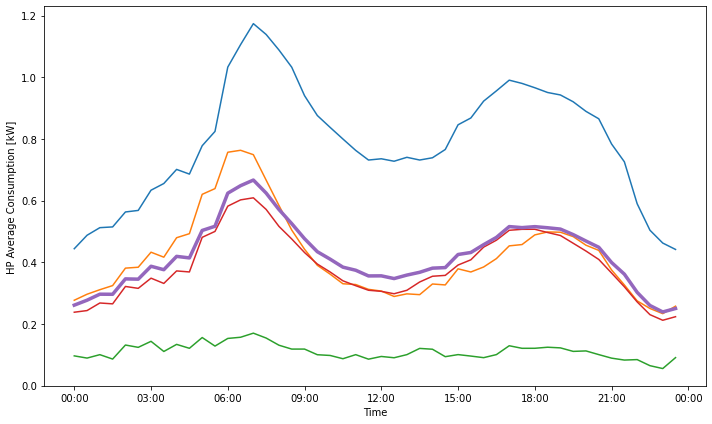

In [12]:
combined_all_df = pd.read_csv('combined_all_df.csv')
combined_winter_df = pd.read_csv('combined_winter_df.csv')
combined_summer_df = pd.read_csv('combined_summer_df.csv')
combined_spring_df = pd.read_csv('combined_spring_df.csv')
combined_autumn_df = pd.read_csv('combined_autumn_df.csv')

combined_all_df['Time'] = pd.to_datetime(combined_all_df['Time'])
combined_winter_df['Time'] = pd.to_datetime(combined_winter_df['Time'])
combined_spring_df['Time'] = pd.to_datetime(combined_spring_df['Time'])
combined_summer_df['Time'] = pd.to_datetime(combined_summer_df['Time'])
combined_autumn_df['Time'] = pd.to_datetime(combined_autumn_df['Time'])

mean_all = combined_all_df.groupby('Time')[columns_to_mean].mean().reset_index()
mean_all['Time'] = pd.to_datetime(mean_all['Time'], format='%H:%M:%S')
# NOTE: some HP don't have the boiler, or backup of immersion coil. QUESTION: what happens to those? Are thy averaged correctly?

winter_mean = combined_winter_df.groupby('Time')[columns_to_mean].mean().reset_index()
winter_mean['Time'] = pd.to_datetime(winter_mean['Time'], format='%H:%M:%S')

spring_mean = combined_spring_df.groupby('Time')[columns_to_mean].mean().reset_index()
spring_mean['Time'] = pd.to_datetime(spring_mean['Time'], format='%H:%M:%S')

summer_mean = combined_summer_df.groupby('Time')[columns_to_mean].mean().reset_index()
summer_mean['Time'] = pd.to_datetime(summer_mean['Time'], format='%H:%M:%S')

autumn_mean = combined_autumn_df.groupby('Time')[columns_to_mean].mean().reset_index()
autumn_mean['Time'] = pd.to_datetime(autumn_mean['Time'], format='%H:%M:%S')

time_periods = {'winter': winter_mean, 'spring': spring_mean, 'summer': summer_mean, 'autumn': autumn_mean, 'full year': mean_all}
fig, ax = plt.subplots(figsize=(10, 6))

for period, df in time_periods.items():
    if period == 'full year':
        ax.plot(df['Time'], df['delta_HP_Consumption'], label=period, linewidth=3.5)  # Thicker line for 'full year'
    else:
        ax.plot(df['Time'], df['delta_HP_Consumption'], label=period)
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time')
ax.set_ylabel('HP Average Consumption [kW]')
#ax.set_title('Average HP Consumption over the year and seasons ')

plt.tight_layout()
#plt.legend()
plt.show()



# Plotting consumption profiles of different data groups 

### ABC & DEF groups

In [14]:
combined_all_df = pd.read_csv('combined_all_df.csv')
combined_all_df = combined_all_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_SHLoad'])
combined_all_df['Time'] = pd.to_datetime(combined_all_df['Time'])

# Split in two dataframes for the corresponing group type
ABC_combined_all_df = combined_all_df[combined_all_df['House_SAP'].isin(['A', 'B', 'C'])]
DEFG_combined_all_df = combined_all_df[combined_all_df['House_SAP'].isin(['D', 'E', 'F'])]

combined_all_df_ids = combined_all_df['Property_ID'].unique().tolist()
ABC_unique_ids = ABC_combined_all_df['Property_ID'].unique().tolist()
DEFG_unique_ids = DEFG_combined_all_df['Property_ID'].unique().tolist()

print(len(combined_all_df_ids))


221


ASHP: 99 percent 0.45
HT_ASHP: 82 percent 0.37
Hybrid: 36 percent 0.16
GSHP: 4 percent 0.02
Total = 353 houses for the seasonal profile.


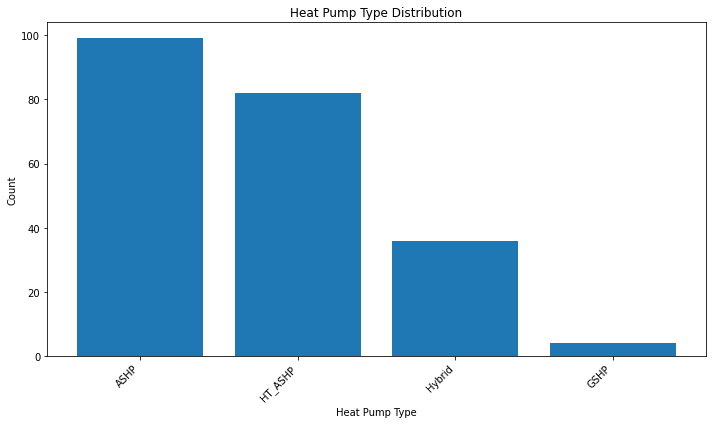

221


In [19]:
first_unique_df = combined_all_df.drop_duplicates(subset=['Property_ID'], keep='first')
unique_values_counts = first_unique_df['HP_Installed'].value_counts()

for value, count in unique_values_counts.items():
    print(f"{value}: {count}", 'percent', round(count/221, 2))

print('Total = 353 houses for the seasonal profile.')
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_values_counts.index, unique_values_counts.values)
plt.xlabel('Heat Pump Type')
plt.ylabel('Count')
plt.title('Heat Pump Type Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(99+82+36+4)

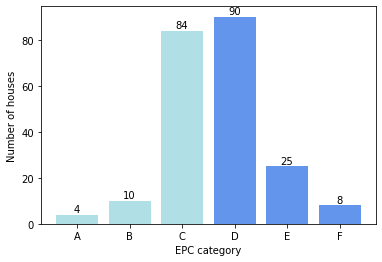

221


In [15]:
# Create a bar plot showing the distribution of houses in different SAP groups
sap_counts_unique = combined_all_df.drop_duplicates(subset='Property_ID')['House_SAP'].value_counts()
categories = ['A', 'B', 'C', 'D', 'E', 'F']
colors = ['powderblue', 'powderblue', 'powderblue', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue']
counts = [sap_counts_unique.get(category, 0) for category in categories]

plt.bar(categories, counts, color=colors)
plt.xlabel('EPC category')
plt.ylabel('Number of houses')
#plt.title('Distribution of houses based on EPC type')

for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center')
plt.show()

print(4+10+84+90+25+8)

In [16]:
# Find the average consumption profile in each group at the time of the day
ABC_mean_all = ABC_combined_all_df.groupby('Time')[columns_to_mean].mean().reset_index()
ABC_mean_all['Time'] = pd.to_datetime(ABC_mean_all['Time'], format='%H:%M:%S')
DEFG_mean_all = DEFG_combined_all_df.groupby('Time')[columns_to_mean].mean().reset_index()
DEFG_mean_all['Time'] = pd.to_datetime(DEFG_mean_all['Time'], format='%H:%M:%S')


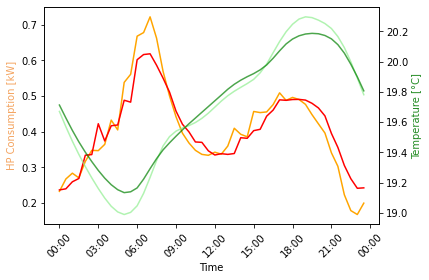

In [17]:
fig, ax1 = plt.subplots()

ax1.plot(ABC_mean_all['Time'], ABC_mean_all['delta_HP_Consumption'], color='orange', label='ABC HP Consumption')
ax1.plot(DEFG_mean_all['Time'], DEFG_mean_all['delta_HP_Consumption'], color='red', label='DEFG HP Consumption')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption [kW]', color='sandybrown')
plt.xticks(rotation=45)
#plt.title('Average yearly HP consumption and indoor \ntemperature profiles for ABC and DEFG houses')

ax2 = ax1.twinx()
ax2.plot(ABC_mean_all['Time'], ABC_mean_all['Internal_Air_Temperature'], color='lightgreen', alpha=0.7 , label='ABC indoor temperature')
ax2.plot(DEFG_mean_all['Time'], DEFG_mean_all['Internal_Air_Temperature'], color='green', alpha=0.7, label='DEFG indoor temperature')
ax2.set_ylabel('Temperature [°C]', color='forestgreen')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2)
plt.show()


In [18]:
# To see correlations between A, B, C, D, E, F we NEED TO DROP A DUMMY. Can do THIS AFTER HAVING CLEANED NOISE (Laura Battaglia feedback)


### Two dataframes with meadian MCS building heat loss values 

In [19]:
combined_all_df = pd.read_csv('combined_all_df.csv') 
combined_all_df = combined_all_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_SHLoad'])

# Split the dataframes in corresponding MCS groups 
unique_values = combined_all_df['MCS_tot_Hloss_kW'].unique().tolist()
unique_values = combined_all_df['MCS_tot_Hloss_kW'].astype(float)
#unique_values = unique_values[~np.isnan(unique_values)] # exclude nan values, nan values exist when MCS or floor are data in BEIS file is empty 
median_MCS_Hloss_value = np.median(unique_values)
print('median_MCS_Hloss_value kW', median_MCS_Hloss_value) 

low_MCS_df_all = combined_all_df[combined_all_df['MCS_tot_Hloss_kW']<=median_MCS_Hloss_value] 
high_MCS_df_all = combined_all_df[combined_all_df['MCS_tot_Hloss_kW']>median_MCS_Hloss_value] 

print('Low MCS HL mean value:', round(low_MCS_df_all['MCS_tot_Hloss_kW'].mean(), 2), 'kW')
print('High MCS HL mean value:', round(high_MCS_df_all['MCS_tot_Hloss_kW'].mean(), 2), 'kW')

unique_ids_low = low_MCS_df_all['Property_ID'].unique().tolist()
unique_ids_high = high_MCS_df_all['Property_ID'].unique().tolist()
print(len(unique_ids_low), len(unique_ids_high))

median_MCS_Hloss_value kW 7.34876
Low MCS HL mean value: 5.46 kW
High MCS HL mean value: 10.4 kW
111 110


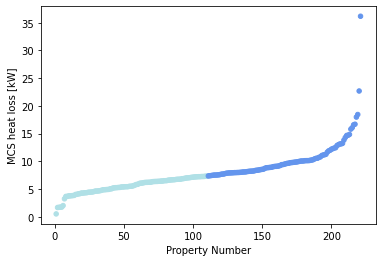

In [20]:
# Plot the distribution of MCS values amongst different houses
single_IDs = combined_all_df.groupby('Property_ID').first().reset_index()
ascending_HL_MCS = single_IDs.sort_values("MCS_tot_Hloss_kW", axis=0, ascending=True, na_position='first')
ascending_HL_MCS['Property_Count'] = range(1, len(ascending_HL_MCS) + 1)

ax = ascending_HL_MCS.plot(x='Property_Count', y='MCS_tot_Hloss_kW', kind='scatter', c=ascending_HL_MCS['MCS_tot_Hloss_kW'].apply(lambda x: 'powderblue' if x < median_MCS_Hloss_value else 'cornflowerblue'))
plt.xlabel('Property Number')
plt.ylabel('MCS heat loss [kW]')
#plt.title('Distribution of MCS heat loss of different houses')
plt.show()


In [21]:
# Find the average consumption and temperature in a day for each MCS HL group 
low_MCS_df = low_MCS_df_all
high_MCS_df = high_MCS_df_all

low_MCS_df['Timestamp'] = pd.to_datetime(low_MCS_df['Time'], format='%Y-%m-%d %H:%M:%S')
low_MCS_df['Time'] = low_MCS_df['Timestamp'].dt.time
low_MCS_df = low_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
low_MCS_df['Time'] = pd.to_datetime(low_MCS_df['Time'], format='%H:%M:%S')

high_MCS_df['Timestamp'] = pd.to_datetime(high_MCS_df['Time'], format='%Y-%m-%d %H:%M:%S')
high_MCS_df['Time'] = high_MCS_df['Timestamp'].dt.time
high_MCS_df = high_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
high_MCS_df['Time'] = pd.to_datetime(high_MCS_df['Time'], format='%H:%M:%S')

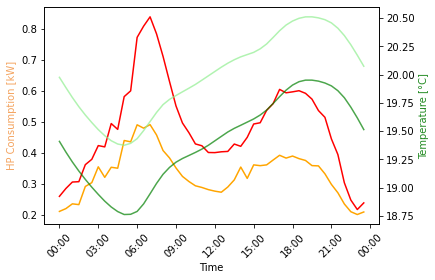

In [22]:
# Plot the group daily consumption and temperature
fig, ax1 = plt.subplots()

ax1.plot(low_MCS_df['Time'], low_MCS_df['delta_HP_Consumption'], color='orange', label='low MCS_HL HP Consumption')
ax1.plot(high_MCS_df['Time'], high_MCS_df['delta_HP_Consumption'], color='red', label='high MCS_HL HP Consumption')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption [kW]', color='sandybrown')
plt.xticks(rotation=45)
#plt.title('Average yearly HP consumption and indoor \ntemperature profiles for low and high MCS heat loss houses')

ax2 = ax1.twinx()
ax2.plot(low_MCS_df['Time'], low_MCS_df['Internal_Air_Temperature'], color='lightgreen', alpha=0.7, label='low MCS indoor temperature')
ax2.plot(high_MCS_df['Time'], high_MCS_df['Internal_Air_Temperature'], color='green', alpha=0.7,  label='high MCS indoor temperature')
ax2.set_ylabel('Temperature [°C]', color='forestgreen')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2)
plt.show()

In [23]:
combined_all_df = pd.read_csv('combined_all_df.csv')
combined_all_df = combined_all_df.dropna(subset=['MCS_tot_Hloss_kW', 'MCS_Hloss', 'Total_Floor_Area', 'MCS_SHLoad'])

x = combined_all_df[['MCS_tot_Hloss_kW']]
y = combined_all_df['delta_HP_Consumption']

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)


                             OLS Regression Results                             
Dep. Variable:     delta_HP_Consumption   R-squared:                       0.054
Model:                              OLS   Adj. R-squared:                  0.054
Method:                   Least Squares   F-statistic:                     968.1
Date:                  Wed, 23 Aug 2023   Prob (F-statistic):          1.02e-206
Time:                          15:47:48   Log-Likelihood:                -3168.1
No. Observations:                 16848   AIC:                             6340.
Df Residuals:                     16846   BIC:                             6356.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

In [24]:
from sklearn.preprocessing import StandardScaler
# standardize x, by subtracting the mean and dividing by standard deviation

x = combined_all_df[['MCS_Hloss', 'Total_Floor_Area']]
y = combined_all_df['delta_HP_Consumption']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_scaled = sm.add_constant(x_scaled)
model = sm.OLS(y, x_scaled).fit()
predictions = model.predict(x_scaled)

print_model = model.summary()
print(print_model)


                             OLS Regression Results                             
Dep. Variable:     delta_HP_Consumption   R-squared:                       0.095
Model:                              OLS   Adj. R-squared:                  0.095
Method:                   Least Squares   F-statistic:                     882.8
Date:                  Wed, 23 Aug 2023   Prob (F-statistic):               0.00
Time:                          15:47:49   Log-Likelihood:                -2799.1
No. Observations:                 16848   AIC:                             5604.
Df Residuals:                     16845   BIC:                             5627.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4222      0.002

In [25]:
x = combined_all_df[['MCS_SHLoad']]
y = combined_all_df['delta_HP_Consumption']

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

                             OLS Regression Results                             
Dep. Variable:     delta_HP_Consumption   R-squared:                       0.063
Model:                              OLS   Adj. R-squared:                  0.063
Method:                   Least Squares   F-statistic:                     1126.
Date:                  Wed, 23 Aug 2023   Prob (F-statistic):          5.07e-239
Time:                          15:47:49   Log-Likelihood:                -3093.7
No. Observations:                 16848   AIC:                             6191.
Df Residuals:                     16846   BIC:                             6207.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2064      0.007

### Two dataframes with meadian MCS space heat loss values 

In [26]:
combined_all_df = pd.read_csv('combined_all_df.csv') 
combined_all_df = combined_all_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_SHLoad'])

# Split the dataframes in corresponding MCS groups 
unique_SHL_values = combined_all_df['MCS_SHLoad'].unique().tolist()
unique_SHL_values = combined_all_df['MCS_SHLoad'].astype(float)
median_MCS_SHL_value = np.median(unique_SHL_values)
print('median_MCS_SHL_value kW', median_MCS_SHL_value) 

SHL_low_MCS_df_all = combined_all_df[combined_all_df['MCS_SHLoad']<=median_MCS_SHL_value] 
SHL_high_MCS_df_all = combined_all_df[combined_all_df['MCS_SHLoad']>median_MCS_SHL_value] 

print('Low MCS SHL mean value:', round(SHL_low_MCS_df_all['MCS_SHLoad'].mean(), 2), 'kW')
print('High MCS SHL mean value:', round(SHL_high_MCS_df_all['MCS_SHLoad'].mean(), 2), 'kW')

SHL_unique_ids_low = SHL_low_MCS_df_all['Property_ID'].unique().tolist()
SHL_unique_ids_high = SHL_high_MCS_df_all['Property_ID'].unique().tolist()

print(len(SHL_unique_ids_low), len(SHL_unique_ids_high))

median_MCS_SHL_value kW 6.8
Low MCS SHL mean value: 5.23 kW
High MCS SHL mean value: 9.3 kW
111 110


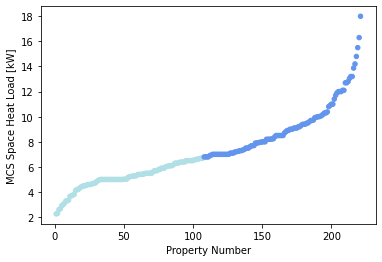

In [27]:
# Plot the distribution of MCS values amongst different houses
single_IDs = combined_all_df.groupby('Property_ID').first().reset_index()
ascending_SHL_MCS = single_IDs.sort_values("MCS_SHLoad", axis=0, ascending=True, na_position='first')
ascending_SHL_MCS['Property_Count'] = range(1, len(ascending_HL_MCS) + 1)

ax = ascending_SHL_MCS.plot(x='Property_Count', y='MCS_SHLoad', kind='scatter', c=ascending_SHL_MCS['MCS_SHLoad'].apply(lambda x: 'powderblue' if x < median_MCS_SHL_value else 'cornflowerblue'))

plt.xlabel('Property Number')
plt.ylabel('MCS Space Heat Load [kW]')
#plt.title('Distribution of MCS space heat load of different houses')
plt.show()

# ascending_HL_MCS


In [28]:
# Find average consumption and temperature etc of the MCS groups by grouping by time of the day
SHL_low_MCS_df = SHL_low_MCS_df_all
SHL_high_MCS_df = SHL_high_MCS_df_all

SHL_low_MCS_df['Timestamp'] = pd.to_datetime(SHL_low_MCS_df['Time'], format='%Y-%m-%d %H:%M:%S')
SHL_low_MCS_df['Time'] = SHL_low_MCS_df['Timestamp'].dt.time
SHL_low_MCS_df = SHL_low_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
SHL_low_MCS_df['Time'] = pd.to_datetime(SHL_low_MCS_df['Time'], format='%H:%M:%S')

SHL_high_MCS_df['Timestamp'] = pd.to_datetime(SHL_high_MCS_df['Time'], format='%Y-%m-%d %H:%M:%S')
SHL_high_MCS_df['Time'] = SHL_high_MCS_df['Timestamp'].dt.time
SHL_high_MCS_df = SHL_high_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
SHL_high_MCS_df['Time'] = pd.to_datetime(SHL_high_MCS_df['Time'], format='%H:%M:%S')

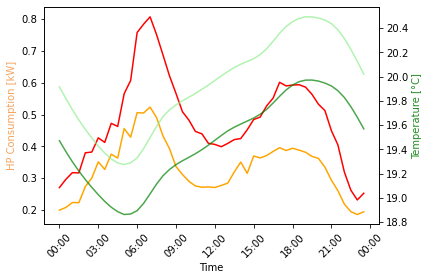

In [29]:
fig, ax1 = plt.subplots()

ax1.plot(SHL_low_MCS_df['Time'], SHL_low_MCS_df['delta_HP_Consumption'], color='orange', label='low MCS_SHL HP Consumption')
ax1.plot(SHL_high_MCS_df['Time'], SHL_high_MCS_df['delta_HP_Consumption'], color='red', label='high MCS_SHL HP Consumption')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption [kW]', color='sandybrown')
plt.xticks(rotation=45)
#plt.title('Daily HP consumption and indoor temperature profiles for low \nand high MCS space heat load houses averaged over the year')

ax2 = ax1.twinx()
ax2.plot(SHL_low_MCS_df['Time'], SHL_low_MCS_df['Internal_Air_Temperature'], color='lightgreen', alpha=0.7, label='low MCS indoor temperature')
ax2.plot(SHL_high_MCS_df['Time'], SHL_high_MCS_df['Internal_Air_Temperature'], color='green', alpha=0.7, label='high MCS indoor temperature')
ax2.set_ylabel('Temperature [°C]', color='forestgreen')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2)
plt.show()

### Comparison of EPC and MCS space heat loss together over the year 

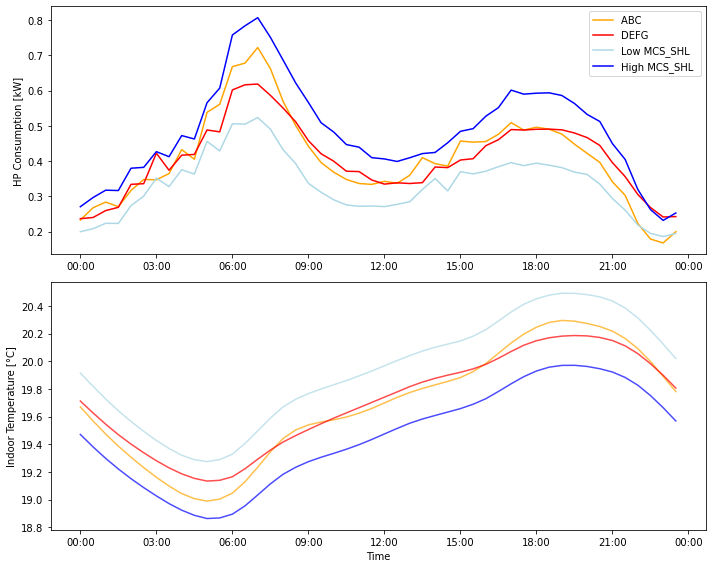

Yearly comparison of consumption and temperature of all EPC vs SHL MCS groups


In [30]:
# Compare them all together between EPC and SHL MCS (not HL) averaged over the year

# Create a figure and two subplots for HP consumption and indoor temperature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# HP Consumption Plot
# Plot HP consumption profiles for average year
ax1.plot(ABC_mean_all['Time'], ABC_mean_all['delta_HP_Consumption'], color='orange', label='ABC ')
ax1.plot(DEFG_mean_all['Time'], DEFG_mean_all['delta_HP_Consumption'], color='red', label='DEFG ')
ax1.plot(SHL_low_MCS_df['Time'], SHL_low_MCS_df['delta_HP_Consumption'], color='lightblue', label='Low MCS_SHL')
ax1.plot(SHL_high_MCS_df['Time'], SHL_high_MCS_df['delta_HP_Consumption'], color='blue', label='High MCS_SHL ')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_ylabel('HP Consumption [kW]')
#ax1.set_title('HP Consumption Profiles')
ax1.legend()

# Indoor Temperature Plot
# Plot indoor temperature profiles for average year
ax2.plot(ABC_mean_all['Time'], ABC_mean_all['Internal_Air_Temperature'], color='orange', alpha=0.7, label='ABC ')
ax2.plot(DEFG_mean_all['Time'], DEFG_mean_all['Internal_Air_Temperature'], color='red', alpha=0.7, label='DEFG ')
ax2.plot(SHL_low_MCS_df['Time'], SHL_low_MCS_df['Internal_Air_Temperature'], color='lightblue', alpha=0.7, label='Low MCS_SHL ')
ax2.plot(SHL_high_MCS_df['Time'], SHL_high_MCS_df['Internal_Air_Temperature'], color='blue', alpha=0.7, label='High MCS_SHL ')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_xlabel('Time')
ax2.set_ylabel('Indoor Temperature [°C]')
#ax2.set_title('Indoor Temperature Profiles')
#ax2.legend()

plt.tight_layout()
plt.show()

print('Yearly comparison of consumption and temperature of all EPC vs SHL MCS groups')


### Properties in different MCS HL and SHL groups

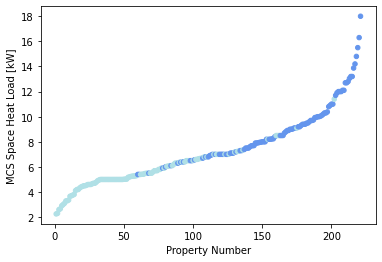

The properties are sorted in ascending MCS SHL values.
The light blue points represent properties in the low MCS HL group. 
The dark blue are properties in high MCS HL group.
The number of properties in low MCS HL not in low MCS SHL: 15


In [31]:
ax = ascending_SHL_MCS.plot(x='Property_Count', y='MCS_SHLoad', kind='scatter', c=ascending_SHL_MCS.apply(lambda row: 'powderblue' if row['Property_ID'] in unique_ids_low else 'cornflowerblue', axis=1))
plt.xlabel('Property Number')
plt.ylabel('MCS Space Heat Load [kW]')
#plt.legend()
plt.show()
print('The properties are sorted in ascending MCS SHL values.\nThe light blue points represent properties in the low MCS HL group. \nThe dark blue are properties in high MCS HL group.')

properties_not_in_SHL = set(unique_ids_low) - set(SHL_unique_ids_low)
print(f"The number of properties in low MCS HL not in low MCS SHL: {len(properties_not_in_SHL)}")

# Coldest day profile comparison

### CD EPC

In [32]:
# Get the coldest day data and divide it in two based on the EPC groups
combined_all_df = pd.read_csv('combined_all_df.csv')
combined_all_df = combined_all_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_SHLoad'])
combined_all_df['Time'] = pd.to_datetime(combined_all_df['Time'])
combined_coldest_day_df = pd.read_csv('combined_coldest_day_df.csv')
combined_coldest_day_df = combined_coldest_day_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_Hloss'])

CD_ABC_combined_all = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(ABC_unique_ids)]
CD_DEFG_combined_all = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(DEFG_unique_ids)]

num_unique_properties_ABC = CD_ABC_combined_all['Property_ID'].nunique()
num_unique_properties_DEFG = CD_DEFG_combined_all['Property_ID'].nunique()
print(f"Number of unique properties in the ABC DataFrame: {num_unique_properties_ABC}")
print(f"Number of unique properties in the DEFG DataFrame: {num_unique_properties_DEFG}")

# Find the average consumption profile in each group 
CD_ABC_mean_all = CD_ABC_combined_all.groupby('Time')[columns_to_mean].mean().reset_index()
CD_DEFG_mean_all = CD_DEFG_combined_all.groupby('Time')[columns_to_mean].mean().reset_index()
CD_ABC_mean_all['Time'] = pd.to_datetime(CD_ABC_mean_all['Time'], format='%H:%M:%S')
CD_DEFG_mean_all['Time'] = pd.to_datetime(CD_DEFG_mean_all['Time'], format='%H:%M:%S')


Number of unique properties in the ABC DataFrame: 98
Number of unique properties in the DEFG DataFrame: 123


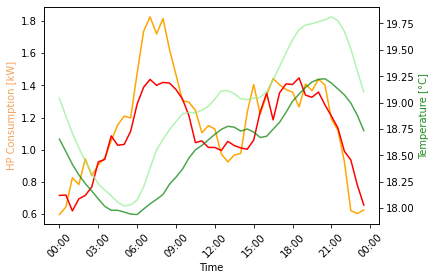

CD Daily HP consumption and indoor temperature profiles for 
ABC and DEF houses averaged on the coldest day


In [33]:
# Plot consumption profile and temperature in two different EPC groups A,B,C and D,E,F 
fig, ax1 = plt.subplots()

ax1.plot(CD_ABC_mean_all['Time'], CD_ABC_mean_all['delta_HP_Consumption'], color='orange', label='ABC HP Consumption')
ax1.plot(CD_DEFG_mean_all['Time'], CD_DEFG_mean_all['delta_HP_Consumption'], color='red', label='DEF HP Consumption')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption [kW]', color='sandybrown')
plt.xticks(rotation=45)
#plt.title('Daily HP consumption and indoor temperature profiles for \nABC and DEF houses averaged on the coldest day')

ax2 = ax1.twinx()
ax2.plot(CD_ABC_mean_all['Time'], CD_ABC_mean_all['Internal_Air_Temperature'], color='lightgreen', alpha=0.7 , label='ABC indoor temperature')
ax2.plot(CD_DEFG_mean_all['Time'], CD_DEFG_mean_all['Internal_Air_Temperature'], color='green', alpha=0.7, label='DEF indoor temperature')
ax2.set_ylabel('Temperature [°C]', color='forestgreen')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2)
plt.show()

print('CD Daily HP consumption and indoor temperature profiles for \nABC and DEF houses averaged on the coldest day')


### CD MCS HL

In [34]:
# Get the coldest day data and divide it in two based on the MCS heat loss calculation 
combined_coldest_day_df = pd.read_csv('combined_coldest_day_df.csv')
# combined_coldest_day_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(combined_all_df_ids)]
combined_coldest_day_df = combined_coldest_day_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_SHLoad'])

CD_low_MCS_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(unique_ids_low)]
CD_high_MCS_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(unique_ids_high)]

num_unique_properties_low_mcs = CD_low_MCS_df['Property_ID'].nunique()
num_unique_properties_high_mcs = CD_high_MCS_df['Property_ID'].nunique()
print(f"Number of unique properties in the low MCS DataFrame: {num_unique_properties_low_mcs}")
print(f"Number of unique properties in the high MCS DataFrame: {num_unique_properties_high_mcs}")

CD_low_MCS_df = CD_low_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
CD_high_MCS_df = CD_high_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
CD_low_MCS_df['Time'] = pd.to_datetime(CD_low_MCS_df['Time'], format='%H:%M:%S')
CD_high_MCS_df['Time'] = pd.to_datetime(CD_high_MCS_df['Time'], format='%H:%M:%S')

Number of unique properties in the low MCS DataFrame: 111
Number of unique properties in the high MCS DataFrame: 110


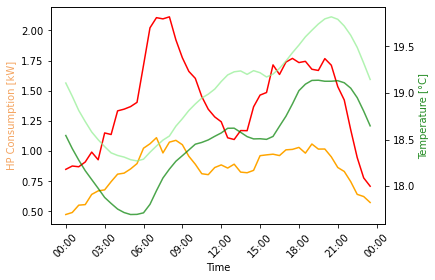

CD Low and high MCS heat loss heat pump consumption and indoor temperature


In [35]:
# Plot consumption profile and temperature in two different MCS heat loss groups
fig, ax1 = plt.subplots()

ax1.plot(CD_low_MCS_df['Time'], CD_low_MCS_df['delta_HP_Consumption'], color='orange', label='low MCS_HL HP Consumption')
ax1.plot(CD_high_MCS_df['Time'], CD_high_MCS_df['delta_HP_Consumption'], color='red', label='high MCS_HL HP Consumption')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption [kW]', color='sandybrown')
plt.xticks(rotation=45)
#plt.title('Daily HP consumption and indoor temperature profiles for low \nand high MCS Heat Loss houses averaged on the coldest day')

ax2 = ax1.twinx()
ax2.plot(CD_low_MCS_df['Time'], CD_low_MCS_df['Internal_Air_Temperature'], color='lightgreen', alpha=0.7, label='low MCS_HL indoor temperature')
ax2.plot(CD_high_MCS_df['Time'], CD_high_MCS_df['Internal_Air_Temperature'], color='green', alpha=0.7, label='high MCS_HL indoor temperature')
ax2.set_ylabel('Temperature [°C]', color='forestgreen')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2)
plt.show()

print('CD Low and high MCS heat loss heat pump consumption and indoor temperature')


### CD MCS SHL

In [36]:
# Get the coldest day data and divide it in two based on the MCS Space heat loss calculation 
combined_coldest_day_df = pd.read_csv('combined_coldest_day_df.csv')
combined_coldest_day_df = combined_coldest_day_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_SHLoad'])

CD_SHL_low_MCS_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(SHL_unique_ids_low)]
CD_SHL_high_MCS_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(SHL_unique_ids_high)]

CD_SHL_low = CD_SHL_low_MCS_df['Property_ID'].unique().tolist()
CD_SHL_high = CD_SHL_high_MCS_df['Property_ID'].unique().tolist()
#SHL_num_unique_properties_low_mcs 
print(f"Number of unique properties in the low MCS SHL DataFrame: {len(CD_SHL_low)}")
print(f"Number of unique properties in the high MCS SHL DataFrame: {len(CD_SHL_high)}")

CD_SHL_low_MCS_df = CD_SHL_low_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
CD_SHL_high_MCS_df = CD_SHL_high_MCS_df.groupby('Time')[columns_to_mean].mean().reset_index()
CD_SHL_low_MCS_df['Time'] = pd.to_datetime(CD_SHL_low_MCS_df['Time'], format='%H:%M:%S')
CD_SHL_high_MCS_df['Time'] = pd.to_datetime(CD_SHL_high_MCS_df['Time'], format='%H:%M:%S')

Number of unique properties in the low MCS SHL DataFrame: 111
Number of unique properties in the high MCS SHL DataFrame: 110


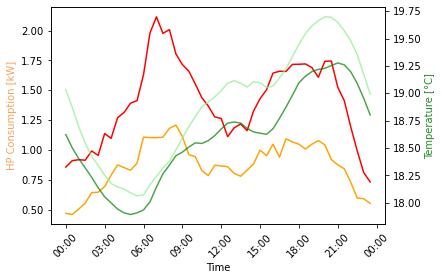

CD Daily HP consumption and indoor temperature profiles for low and 
high MCS SHL houses averaged on the coldest day


In [37]:
# Plot consumption profile and temperature in two different MCS Space Heat Load groups
fig, ax1 = plt.subplots()

ax1.plot(CD_SHL_low_MCS_df['Time'], CD_SHL_low_MCS_df['delta_HP_Consumption'], color='orange', label='low MCS_SHL HP Consumption')
ax1.plot(CD_SHL_high_MCS_df['Time'], CD_SHL_high_MCS_df['delta_HP_Consumption'], color='red', label='high MCS_SHL HP Consumption')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption [kW]', color='sandybrown')
plt.xticks(rotation=45)
#plt.title('Daily HP consumption and indoor temperature profiles for low and \nhigh MCS Space Heat Load houses averaged on the coldest day')

ax2 = ax1.twinx()
ax2.plot(CD_SHL_low_MCS_df['Time'], CD_SHL_low_MCS_df['Internal_Air_Temperature'], color='lightgreen', alpha=0.7, label='low MCS_SHL indoor temperature')
ax2.plot(CD_SHL_high_MCS_df['Time'], CD_SHL_high_MCS_df['Internal_Air_Temperature'], color='green', alpha=0.7, label='high MCS_SHL indoor temperature')
ax2.set_ylabel('Temperature [°C]', color='forestgreen')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2)
plt.show()

print('CD Daily HP consumption and indoor temperature profiles for low and \nhigh MCS SHL houses averaged on the coldest day')


### Compare them all together on the coldest day 

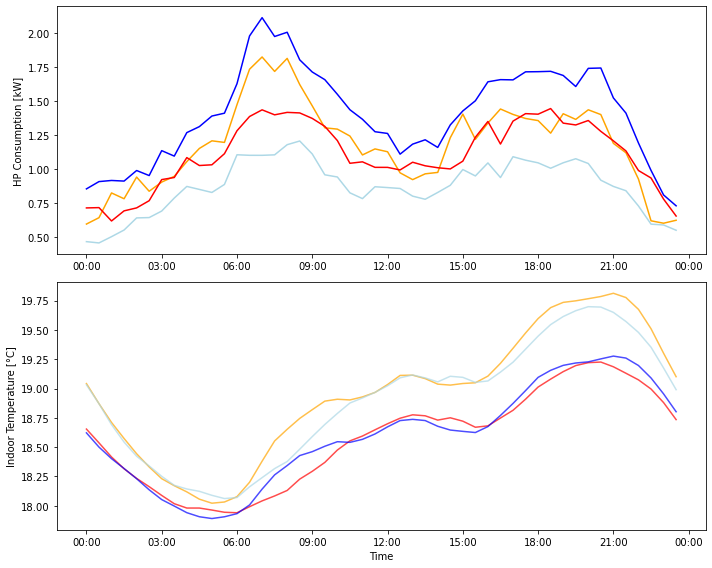

CD comparison of consumption and temperature of all EPC vs SHL MCS groups


In [38]:
# Compare them all together between EPC and MCS SHL averaged over the year!!!
# Create a figure and two subplots for HP consumption and indoor temperature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# HP Consumption Plot
# Plot HP consumption profiles for average year
ax1.plot(CD_ABC_mean_all['Time'], CD_ABC_mean_all['delta_HP_Consumption'], color='orange', label='ABC Coldest Day')
ax1.plot(CD_DEFG_mean_all['Time'], CD_DEFG_mean_all['delta_HP_Consumption'], color='red', label='DEFG Coldest Day')
ax1.plot(CD_SHL_low_MCS_df['Time'], CD_SHL_low_MCS_df['delta_HP_Consumption'], color='lightblue', label='Low MCS_SHL Coldest Day')
ax1.plot(CD_SHL_high_MCS_df['Time'], CD_SHL_high_MCS_df['delta_HP_Consumption'], color='blue', label='High MCS_SHL Coldest Day')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_ylabel('HP Consumption [kW]')
#ax1.set_title('HP Consumption Profiles')
#ax1.legend()

# Indoor Temperature Plot
# Plot indoor temperature profiles for average year
ax2.plot(CD_ABC_mean_all['Time'], CD_ABC_mean_all['Internal_Air_Temperature'], color='orange', alpha=0.7, label='ABC Coldest Day')
ax2.plot(CD_DEFG_mean_all['Time'], CD_DEFG_mean_all['Internal_Air_Temperature'], color='red', alpha=0.7, label='DEFG Coldest Day')
ax2.plot(CD_SHL_low_MCS_df['Time'], CD_SHL_low_MCS_df['Internal_Air_Temperature'], color='lightblue', alpha=0.7, label='Low MCS_SHL Coldest Day')
ax2.plot(CD_SHL_high_MCS_df['Time'], CD_SHL_high_MCS_df['Internal_Air_Temperature'], color='blue', alpha=0.7, label='High MCS_SHL Coldest Day')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_xlabel('Time')
ax2.set_ylabel('Indoor Temperature [°C]')
#ax2.set_title('Indoor Temperature Profiles')
#ax2.legend()

plt.tight_layout()
plt.show()

print('CD comparison of consumption and temperature of all EPC vs SHL MCS groups')


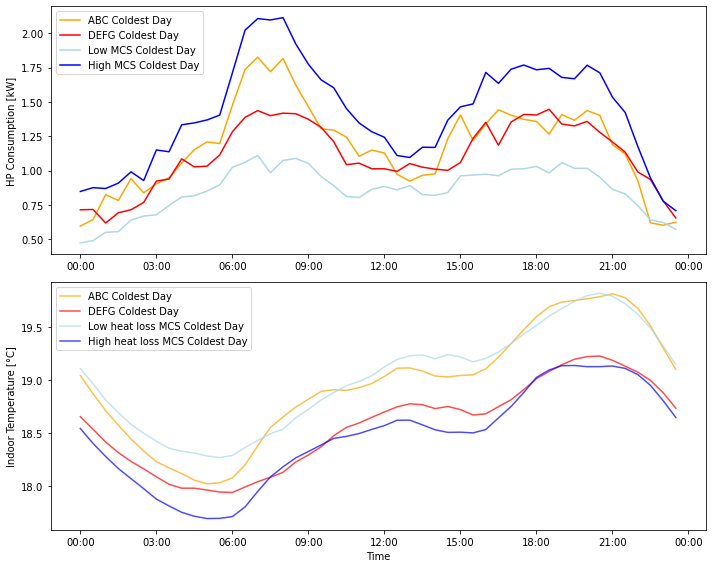

EPC vs HL MCS averaged over the coldest day


In [39]:
# Compare them all together between EPC and MCS HL averaged over the year!!!
# Create a figure and two subplots for HP consumption and indoor temperature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# HP Consumption Plot
# Plot HP consumption profiles for average year
ax1.plot(CD_ABC_mean_all['Time'], CD_ABC_mean_all['delta_HP_Consumption'], color='orange', label='ABC Coldest Day')
ax1.plot(CD_DEFG_mean_all['Time'], CD_DEFG_mean_all['delta_HP_Consumption'], color='red', label='DEFG Coldest Day')
ax1.plot(CD_low_MCS_df['Time'], CD_low_MCS_df['delta_HP_Consumption'], color='lightblue', label='Low MCS Coldest Day')
ax1.plot(CD_high_MCS_df['Time'], CD_high_MCS_df['delta_HP_Consumption'], color='blue', label='High MCS Coldest Day')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_ylabel('HP Consumption [kW]')
#ax1.set_title('HP Consumption Profiles')
ax1.legend()

# Indoor Temperature Plot
# Plot indoor temperature profiles for average year
ax2.plot(CD_ABC_mean_all['Time'], CD_ABC_mean_all['Internal_Air_Temperature'], color='orange', alpha=0.7, label='ABC Coldest Day')
ax2.plot(CD_DEFG_mean_all['Time'], CD_DEFG_mean_all['Internal_Air_Temperature'], color='red', alpha=0.7, label='DEFG Coldest Day')
ax2.plot(CD_low_MCS_df['Time'], CD_low_MCS_df['Internal_Air_Temperature'], color='lightblue', alpha=0.7, label='Low heat loss MCS Coldest Day')
ax2.plot(CD_high_MCS_df['Time'], CD_high_MCS_df['Internal_Air_Temperature'], color='blue', alpha=0.7, label='High heat loss MCS Coldest Day')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_xlabel('Time')
ax2.set_ylabel('Indoor Temperature [°C]')
#ax2.set_title('Indoor Temperature Profiles')
ax2.legend()

plt.tight_layout()
plt.show()

print('EPC vs HL MCS averaged over the coldest day')


## Bar graphs comparing EPC vs MCS SHL consumption and SPFHn

### Year average

In [40]:
# find the total mean of heat pump consumption over the selected window
ABC_avg_HP = ABC_mean_all['delta_HP_Consumption'].mean() # window mean
DEFG_avg_HP = DEFG_mean_all['delta_HP_Consumption'].mean()
lowMCS_avg_HP = low_MCS_df['delta_HP_Consumption'].mean()
highMCS_avg_HP = high_MCS_df['delta_HP_Consumption'].mean()
SHL_lowMCS_avg_HP = SHL_low_MCS_df['delta_HP_Consumption'].mean()
SHL_highMCS_avg_HP = SHL_high_MCS_df['delta_HP_Consumption'].mean()

#ABC_combined_all_df['CD_SPFH2']
# Extract the total average SPFHn of all houses in group
ABC_SPFH2, ABC_SPFH3, ABC_SPFH4 = extract_SPFn(ABC_combined_all_df)   
DEFG_SPFH2, DEFG_SPFH3, DEFG_SPFH4 = extract_SPFn(DEFG_combined_all_df)   
lowMCS_SPFH2, lowMCS_SPFH3, lowMCS_SPFH4 = extract_SPFn(low_MCS_df_all)   
highMCS_SPFH2, highMCS_SPFH3, highMCS_SPFH4 = extract_SPFn(high_MCS_df_all)
SHL_lowMCS_SPFH2, SHL_lowMCS_SPFH3, SHL_lowMCS_SPFH4 = extract_SPFn(SHL_low_MCS_df_all)   
SHL_highMCS_SPFH2, SHL_highMCS_SPFH3, SHL_highMCS_SPFH4 = extract_SPFn(SHL_high_MCS_df_all)

print("Number of unique houses in ABC group: ", len(ABC_unique_ids), 'and',len(DEFG_unique_ids), 'in DEFG group.\n', ABC_avg_HP, DEFG_avg_HP ) 
print("Number of unique houses in low MCS group: ", len(unique_ids_low), 'and',len(unique_ids_high), 'in high MCS group.\n', lowMCS_avg_HP, highMCS_avg_HP ) 
print("Number of unique houses in low MCS group: ", len(SHL_unique_ids_low), 'and',len(SHL_unique_ids_high), 'in high MCS Space Heat Load group.\n', SHL_lowMCS_avg_HP, SHL_highMCS_avg_HP ) 

Number of unique houses in ABC group:  98 and 123 in DEFG group.
 0.40841251793317945 0.4084293862632457
Number of unique houses in low MCS group:  111 and 110 in high MCS group.
 0.33296134600748134 0.48456847146364007
Number of unique houses in low MCS group:  111 and 110 in high MCS Space Heat Load group.
 0.33357910669903473 0.4839450947657998


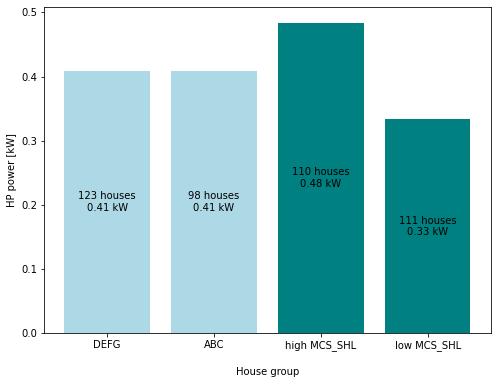

Daily heat pump power averaged over the year by category
DO THIS ALSO FOR COLDEST DAY TO SEE THE DIFFERENCE?


In [41]:
categories = ['DEFG', 'ABC', 'high MCS_SHL', 'low MCS_SHL' ]
avg_HP_values = [DEFG_avg_HP, ABC_avg_HP, SHL_highMCS_avg_HP, SHL_lowMCS_avg_HP]
unique_property_ids = [len(DEFG_unique_ids), len(ABC_unique_ids), len(SHL_unique_ids_high), len(SHL_unique_ids_low) ]
colors = ['lightblue', 'lightblue', 'teal', 'teal']
plt.figure(figsize=(8, 6))

plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('HP power [kW]')
plt.xlabel('\nHouse group')

#plt.title('Daily heat pump power averaged over the year by category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} kW", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} kW", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

print('Daily heat pump power averaged over the year by category')
print('DO THIS ALSO FOR COLDEST DAY TO SEE THE DIFFERENCE?')

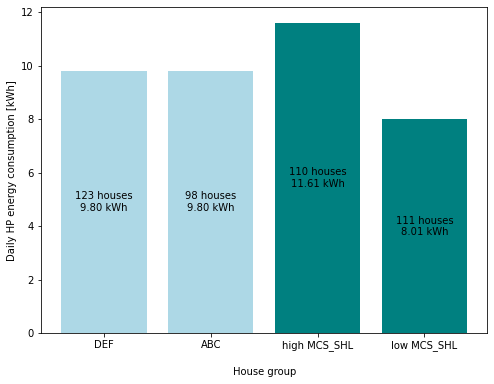

Daily heat pump energy consumption averaged over the year by house category
DEF = 123 houses
ABC = 98 houses
high MCS SHL = 110 houses
low MCS SHL = 111 houses


In [42]:
categories = ['DEF', 'ABC', 'high MCS_SHL', 'low MCS_SHL' ]
avg_HP_values = [DEFG_avg_HP*24, ABC_avg_HP*24, SHL_highMCS_avg_HP*24, SHL_lowMCS_avg_HP*24]
unique_property_ids = [len(DEFG_unique_ids), len(ABC_unique_ids), len(SHL_unique_ids_high), len(SHL_unique_ids_low), ]
colors = ['lightblue', 'lightblue', 'teal', 'teal']
plt.figure(figsize=(8, 6))

plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('Daily HP energy consumption [kWh]')
plt.xlabel('\nHouse group')
#plt.title('Daily heat pump energy consumption averaged over the year by house category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

print('Daily heat pump energy consumption averaged over the year by house category')
print('DEF = 123 houses\nABC = 98 houses\nhigh MCS SHL = 110 houses\nlow MCS SHL = 111 houses')


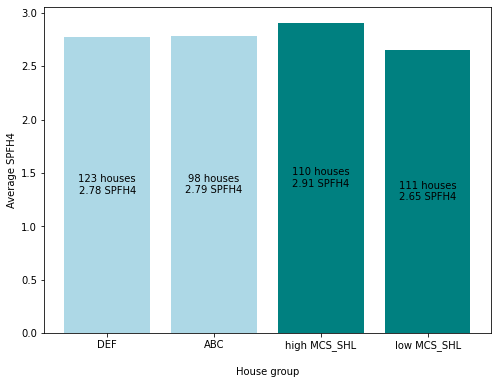

Average SPFH4 by house category


In [43]:
categories = ['DEF', 'ABC', 'high MCS_SHL', 'low MCS_SHL' ]
avg_HP_values = [DEFG_SPFH4, ABC_SPFH4, SHL_highMCS_SPFH4, SHL_lowMCS_SPFH4]
#avg_HP_values = [DEFG_SPFH2, ABC_SPFH2, highMCS_SPFH2, lowMCS_SPFH2]
#unique_property_ids = [len(D_unique_ids), len(A_unique_ids), num_unique_high, num_unique_low]
colors = ['lightblue', 'lightblue', 'teal', 'teal']

plt.figure(figsize=(8, 6))
plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('Average SPFH4')
plt.xlabel('\nHouse group')
#plt.title('Average SPFH4 by house category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} SPFH4", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} SPFH4", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

print('Average SPFH4 by house category')


### Coldest day average 

In [44]:
# find the total mean of heat pump consumption over the selected window
CD_ABC_avg_HP = CD_ABC_mean_all['delta_HP_Consumption'].mean() # window mean
CD_DEFG_avg_HP = CD_DEFG_mean_all['delta_HP_Consumption'].mean()
CD_SHL_lowMCS_avg_HP = CD_SHL_low_MCS_df['delta_HP_Consumption'].mean()
CD_SHL_highMCS_avg_HP = CD_SHL_high_MCS_df['delta_HP_Consumption'].mean()
#CD_ABC_SPFH2 = CD_ABC_mean_all['avg_CD_SPFH2'].mean()

print("Number of unique houses in ABC group: ", num_unique_properties_ABC, 'and', num_unique_properties_DEFG, 'in DEFG group.\n', CD_ABC_avg_HP, CD_DEFG_avg_HP ) 
print("Number of unique houses in low MCS group: ", len(CD_SHL_low), 'and',len(CD_SHL_high), 'in high MCS Space Heat Load group.\n', CD_SHL_lowMCS_avg_HP, CD_SHL_highMCS_avg_HP ) 


Number of unique houses in ABC group:  98 and 123 in DEFG group.
 1.17858865616837 1.1097058724390838
Number of unique houses in low MCS group:  111 and 110 in high MCS Space Heat Load group.
 0.8737309375979078 1.4048899750817354


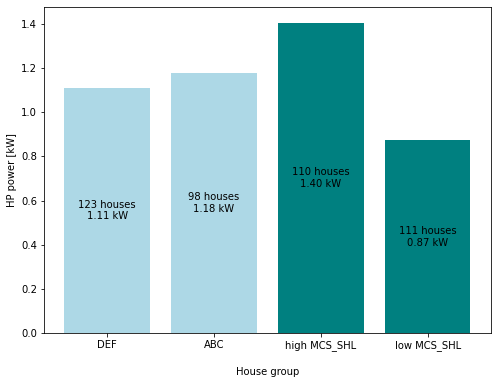

Daily heat pump power averaged over the coldest day by category


In [45]:
categories = ['DEF', 'ABC', 'high MCS_SHL', 'low MCS_SHL' ]
avg_HP_values = [CD_DEFG_avg_HP, CD_ABC_avg_HP, CD_SHL_highMCS_avg_HP, CD_SHL_lowMCS_avg_HP]
unique_property_ids = [num_unique_properties_DEFG, num_unique_properties_ABC, len(CD_SHL_high), len(CD_SHL_low)]
# unique_property_ids = [num_unique_properties_DEFG, num_unique_properties_ABC, len(CD_SHL_high_MCS_df), len(CD_SHL_low_MCS_df) ]
colors = ['lightblue', 'lightblue', 'teal', 'teal']
plt.figure(figsize=(8, 6))

plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('HP power [kW]')
plt.xlabel('\nHouse group')
#plt.title('Daily heat pump power averaged over the year by category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} kW", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} kW", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

print('Daily heat pump power averaged over the coldest day by category')


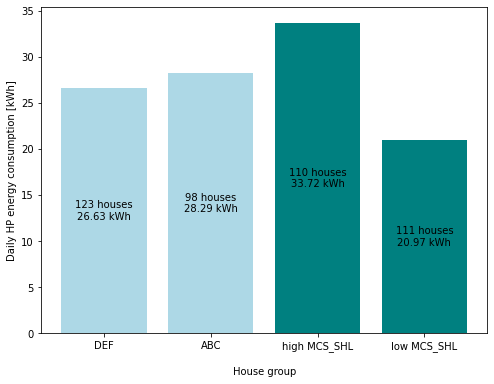

Daily heat pump energy consumption averaged over the coldest day by category


In [46]:
categories = ['DEF', 'ABC', 'high MCS_SHL', 'low MCS_SHL' ]
avg_HP_values = [CD_DEFG_avg_HP*24, CD_ABC_avg_HP*24, CD_SHL_highMCS_avg_HP*24, CD_SHL_lowMCS_avg_HP*24]
unique_property_ids = [num_unique_properties_DEFG, num_unique_properties_ABC, len(CD_SHL_high), len(CD_SHL_low)]
# unique_property_ids = [num_unique_properties_DEFG, num_unique_properties_ABC, len(CD_SHL_high_MCS_df), len(CD_SHL_low_MCS_df) ]
colors = ['lightblue', 'lightblue', 'teal', 'teal']
plt.figure(figsize=(8, 6))

plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('Daily HP energy consumption [kWh]')
plt.xlabel('\nHouse group')
#plt.title('Daily heat pump power averaged over the year by category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

print('Daily heat pump energy consumption averaged over the coldest day by category')


In [47]:
combined_coldest_day_df = pd.read_csv('combined_coldest_day_df.csv')
combined_coldest_day_df = combined_coldest_day_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_Hloss'])
CD_ids = combined_coldest_day_df['Property_ID'].unique().tolist()
#print(len(CD_ids), len(CD_SHL_high) + len(CD_SHL_low), len(DEFG_unique_ids) + len(ABC_unique_ids))

CD_ABC_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(ABC_unique_ids)]
CD_DEFG_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(DEFG_unique_ids)]

CD_DEFG_unique_ids = CD_DEFG_df['Property_ID'].unique().tolist()
CD_ABC_unique_ids = CD_ABC_df['Property_ID'].unique().tolist()
print(len(CD_DEFG_unique_ids) + len(CD_ABC_unique_ids) )

CD_SHL_high_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(CD_SHL_high)]
CD_SHL_low_df = combined_coldest_day_df[combined_coldest_day_df['Property_ID'].isin(CD_SHL_low)]

avg_CD_SPFH4_SHL_high = CD_SHL_high_df['avg_CD_SPFH4'].mean()
avg_CD_SPFH4_SHL_low = CD_SHL_low_df['avg_CD_SPFH4'].mean()

avg_CD_SPFH4_ABC = CD_ABC_df['avg_CD_SPFH4'].mean()
avg_CD_SPFH4_DEFG = CD_DEFG_df['avg_CD_SPFH4'].mean()

print(avg_CD_SPFH4_ABC, avg_CD_SPFH4_DEFG, '\n', avg_CD_SPFH4_SHL_low, avg_CD_SPFH4_SHL_high)
print((avg_CD_SPFH4_ABC+avg_CD_SPFH4_DEFG)/2, (avg_CD_SPFH4_SHL_low+avg_CD_SPFH4_SHL_high)/2)

#avg_SPFH4_SHL_high = CD_SHL_high_df['SPFH4'].mean()
#avg_SPFH4_SHL_low = CD_SHL_low_df['SPFH4'].mean()
#print(avg_SPFH4_SHL_high, avg_CD_SPFH4_SHL_high, '\n', avg_SPFH4_SHL_low, avg_CD_SPFH4_SHL_low)


221
2.6122026775111378 2.2034753167409997 
 2.4168662600222004 2.3561632125394056
2.4078389971260687 2.386514736280803


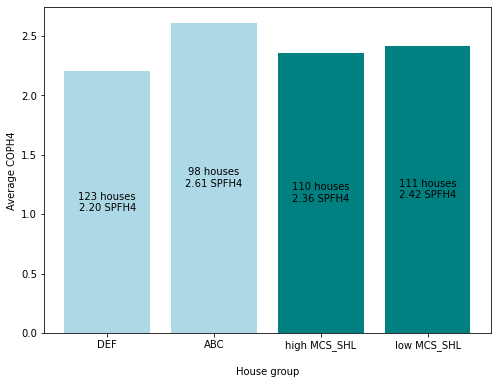

Average SPFH4 by house category on the Coldest day


In [48]:
categories = ['DEF', 'ABC', 'high MCS_SHL', 'low MCS_SHL' ]
avg_HP_values = [avg_CD_SPFH4_DEFG, avg_CD_SPFH4_ABC, avg_CD_SPFH4_SHL_high, avg_CD_SPFH4_SHL_low]
#avg_HP_values = [DEFG_SPFH2, ABC_SPFH2, highMCS_SPFH2, lowMCS_SPFH2]
#unique_property_ids = [len(D_unique_ids), len(A_unique_ids), num_unique_high, num_unique_low]
colors = ['lightblue', 'lightblue', 'teal', 'teal']

plt.figure(figsize=(8, 6))
plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('Average COPH4')
plt.xlabel('\nHouse group')
#plt.title('Average SPFH4 by house category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} COPH4", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} SPFH4", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

print('Average SPFH4 by house category on the Coldest day')


# Bar graphs showing year and coldest day consumption 

In [49]:
combined_coldest_day_df = pd.read_csv('combined_coldest_day_df.csv')
combined_coldest_day_df = combined_coldest_day_df.dropna(subset=['MCS_tot_Hloss_kW', 'House_SAP', 'MCS_Hloss'])
CD_ids = combined_coldest_day_df['Property_ID'].unique().tolist()

print(len(CD_ids))

221


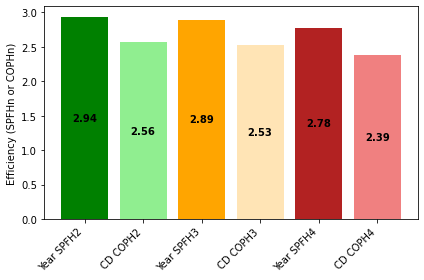

Average SPFHn over the year vs. coldest day


In [50]:
avg_year_SPFH2 = combined_coldest_day_df['SPFH2'].mean()
avg_tot_CD_SPFH2 = combined_coldest_day_df['avg_CD_SPFH2'].mean()
avg_year_SPFH3 = combined_coldest_day_df['SPFH3'].mean()
avg_tot_CD_SPFH3 = combined_coldest_day_df['avg_CD_SPFH3'].mean()
avg_year_SPFH4 = combined_coldest_day_df['SPFH4'].mean()
avg_tot_CD_SPFH4 = combined_coldest_day_df['avg_CD_SPFH4'].mean()

x = ['Year SPFH2', 'CD COPH2', 'Year SPFH3', 'CD COPH3', 'Year SPFH4', 'CD COPH4']
y = [avg_year_SPFH2, avg_tot_CD_SPFH2, avg_year_SPFH3, avg_tot_CD_SPFH3, avg_year_SPFH4, avg_tot_CD_SPFH4]
colors = ['green', 'lightgreen', 'orange', 'moccasin', 'firebrick', 'lightcoral']

fig, ax = plt.subplots()
bars = ax.bar(x, y, color=colors)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval / 2, round(yval, 2),
            ha='center', va='center', color='black', fontweight='bold')

plt.ylabel('Efficiency (SPFHn or COPHn)')
#plt.title('Average SPFHn over the year vs. coldest day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('Average SPFHn over the year vs. coldest day')

# Should I exclude the hybrid systems? with a boiler etc
# These results help debugging the myth that HP are not performing when it's cold?? 

In [51]:
grouped_data = combined_coldest_day_df.groupby('Property_ID')
data = { 'heat_loss': [], 'min_temp': [], 'six_pm_temp': [], 'max_power': [], 'Property_ID': [], 'MCS_SHL': [],
        'Total_Floor_Area': [],'House_SAP': [], 'mean_HP_power': []}

for property_id, group in grouped_data:
    data['heat_loss'].append(group['MCS_tot_Hloss_kW'].iloc[0])
    data['min_temp'].append(group['min_Internal_Air_Temperature'].iloc[0])
    data['six_pm_temp'].append(group['CD_six_pm_temp'].iloc[0])
    data['mean_HP_power'].append(group['mean_HP_cons'].iloc[0]) ######################
    data['max_power'].append(group['max_HP_power_cons'].iloc[0])
    data['Property_ID'].append(property_id)
    data['MCS_SHL'].append(group['MCS_SHLoad'].iloc[0])
    data['Total_Floor_Area'].append(group['Total_Floor_Area'].iloc[0])
    data['House_SAP'].append(group['House_SAP'].iloc[0])

dataframe = pd.DataFrame(data)

filtered_power_df = dataframe[dataframe['max_power'] >= 0.5]
df_cleaned = filtered_power_df[filtered_power_df['six_pm_temp'] >= 4.0].dropna()

Uncertainty (std error) of the linear fit for min_temp x (MCS +- ΔkW) and y (+- ΔT): [0.04422576 0.39592572]
Uncertainty (std error) of the linear fit for max_power x (MCS +- ΔkW) and y (HP +- ΔkW): [0.02096131 0.18765361]


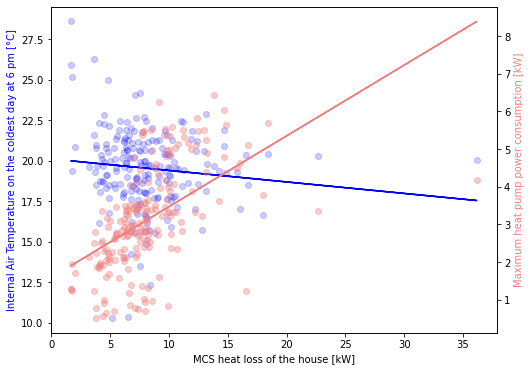

In [52]:
#plt.figure(figsize=(8, 6))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

ax1.scatter(df_cleaned['heat_loss'], df_cleaned['six_pm_temp'], color='blue', alpha=0.2, label='6 pm temperature')
ax2.scatter(df_cleaned['heat_loss'], df_cleaned['max_power'], color='lightcoral', alpha=0.4, label='max_power')
ax1.set_xlabel('MCS heat loss of the house [kW]')
ax1.set_ylabel('Internal Air Temperature on the coldest day at 6 pm [°C]', color='blue')
ax2.set_ylabel('Maximum heat pump power consumption [kW]', color='lightcoral')

# Fit a polynomial regression line (1st degree) to the data points
coeffs_temp, cov_temp = np.polyfit(df_cleaned['heat_loss'], df_cleaned['six_pm_temp'], 1, cov=True)
line_temp = np.poly1d(coeffs_temp)
ax1.plot(df_cleaned['heat_loss'], line_temp(df_cleaned['heat_loss']), color='blue')
coeffs_power, cov_power = np.polyfit(df_cleaned['heat_loss'], df_cleaned['max_power'], 1, cov=True)
line_power = np.poly1d(coeffs_power)
ax2.plot(df_cleaned['heat_loss'], line_power(df_cleaned['heat_loss']), color='lightcoral')

# Calculate the uncertainties (standard errors)
std_err_temp = np.sqrt(np.diag(cov_temp)) # Check that this is correct! should return an error on MCS +- ΔkW, and +- ΔT
std_err_power = np.sqrt(np.diag(cov_power)) # Check that this is correct! should return an error on MCS +- ΔkW, and HP +- ΔkW 

print("Uncertainty (std error) of the linear fit for min_temp x (MCS +- ΔkW) and y (+- ΔT):", std_err_temp)
print("Uncertainty (std error) of the linear fit for max_power x (MCS +- ΔkW) and y (HP +- ΔkW):", std_err_power)
plt.show()

# QUESTION: should I plot this for average internal temperature and average HP consumption?
# QUESTION: should I take away the boiler types?

Uncertainty (std error) of the linear fit for min_temp x (MCS +- ΔkW) and y (+- ΔT): [0.04422576 0.39592572]
Uncertainty (std error) of the linear fit for max_power x (MCS +- ΔkW) and y (HP +- ΔkW): [0.0107842 0.0965442]


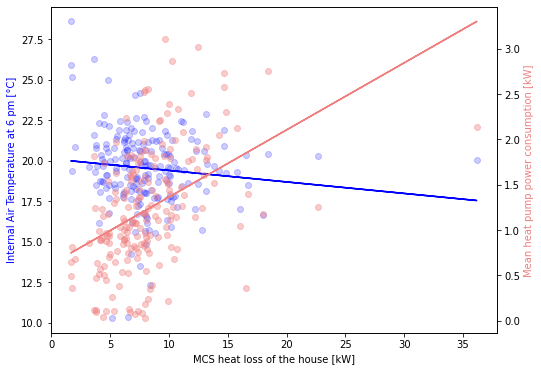

MCS HL Analysis on the coldest day


In [53]:
#plt.figure(figsize=(8, 6))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

ax1.scatter(df_cleaned['heat_loss'], df_cleaned['six_pm_temp'], color='blue', alpha=0.2, label='6 pm temperature')
ax2.scatter(df_cleaned['heat_loss'], df_cleaned['mean_HP_power'], color='lightcoral', alpha=0.4, label='mean_HP_power')
ax1.set_xlabel('MCS heat loss of the house [kW]')
ax1.set_ylabel('Internal Air Temperature at 6 pm [°C]', color='blue')
ax2.set_ylabel('Mean heat pump power consumption [kW]', color='lightcoral')

# Fit a polynomial regression line (1st degree) to the data points
coeffs_temp, cov_temp = np.polyfit(df_cleaned['heat_loss'], df_cleaned['six_pm_temp'], 1, cov=True)
line_temp = np.poly1d(coeffs_temp)
ax1.plot(df_cleaned['heat_loss'], line_temp(df_cleaned['heat_loss']), color='blue')
coeffs_power, cov_power = np.polyfit(df_cleaned['heat_loss'], df_cleaned['mean_HP_power'], 1, cov=True)
line_power = np.poly1d(coeffs_power)
ax2.plot(df_cleaned['heat_loss'], line_power(df_cleaned['heat_loss']), color='lightcoral')

# Calculate the uncertainties (standard errors)
std_err_temp = np.sqrt(np.diag(cov_temp)) # Check that this is correct! should return an error on MCS +- ΔkW, and +- ΔT
std_err_power = np.sqrt(np.diag(cov_power)) # Check that this is correct! should return an error on MCS +- ΔkW, and HP +- ΔkW 

print("Uncertainty (std error) of the linear fit for min_temp x (MCS +- ΔkW) and y (+- ΔT):", std_err_temp)
print("Uncertainty (std error) of the linear fit for max_power x (MCS +- ΔkW) and y (HP +- ΔkW):", std_err_power)
plt.show()


# QUESTION: should I plot this for average internal temperature and average HP consumption?
# QUESTION: should I take away the boiler types?

print('MCS HL Analysis on the coldest day')

Uncertainty (std error) of the linear fit for min_temp x (MCS +- ΔkW) and y (+- ΔT): [0.06025093 0.47438031]
Uncertainty (std error) of the linear fit for max_power x (MCS +- ΔkW) and y (HP +- ΔkW): [0.01470911 0.11581085]


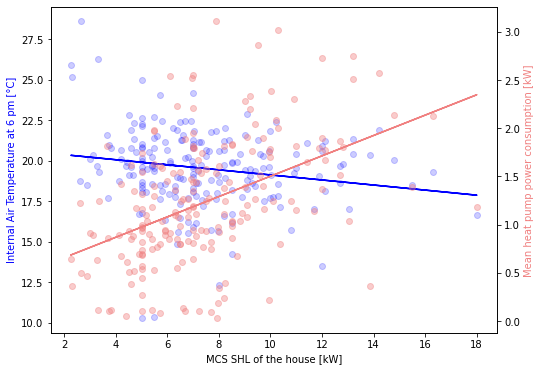

HP consumption and 6pm temperature analysis on the coldest day based on MCS SHL


In [54]:
#plt.figure(figsize=(8, 6))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

ax1.scatter(df_cleaned['MCS_SHL'], df_cleaned['six_pm_temp'], color='blue', alpha=0.2, label='6 pm temperature')
ax2.scatter(df_cleaned['MCS_SHL'], df_cleaned['mean_HP_power'], color='lightcoral', alpha=0.4, label='mean_HP_power')
ax1.set_xlabel('MCS SHL of the house [kW]')
ax1.set_ylabel('Internal Air Temperature at 6 pm [°C]', color='blue')
ax2.set_ylabel('Mean heat pump power consumption [kW]', color='lightcoral')

# Fit a polynomial regression line (1st degree) to the data points
coeffs_temp, cov_temp = np.polyfit(df_cleaned['MCS_SHL'], df_cleaned['six_pm_temp'], 1, cov=True)
line_temp = np.poly1d(coeffs_temp)
ax1.plot(df_cleaned['MCS_SHL'], line_temp(df_cleaned['MCS_SHL']), color='blue')
coeffs_power, cov_power = np.polyfit(df_cleaned['MCS_SHL'], df_cleaned['mean_HP_power'], 1, cov=True)
line_power = np.poly1d(coeffs_power)
ax2.plot(df_cleaned['MCS_SHL'], line_power(df_cleaned['MCS_SHL']), color='lightcoral')

# Calculate the uncertainties (standard errors)
std_err_temp = np.sqrt(np.diag(cov_temp)) # Check that this is correct! should return an error on MCS +- ΔkW, and +- ΔT
std_err_power = np.sqrt(np.diag(cov_power)) # Check that this is correct! should return an error on MCS +- ΔkW, and HP +- ΔkW 

print("Uncertainty (std error) of the linear fit for min_temp x (MCS +- ΔkW) and y (+- ΔT):", std_err_temp)
print("Uncertainty (std error) of the linear fit for max_power x (MCS +- ΔkW) and y (HP +- ΔkW):", std_err_power)
plt.show()


# QUESTION: should I plot this for average internal temperature and average HP consumption?
# QUESTION: should I take away the boiler types?

print('HP consumption and 6pm temperature analysis on the coldest day based on MCS SHL')

221


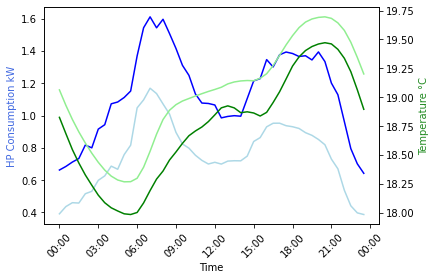

Coldest day and winter average HP Consumption and Internal Air Temperature daily profile


In [55]:
# Find the avarage profile on the coldest day 
CD_mean_all = combined_coldest_day_df.groupby('Time')[columns_to_mean].mean().reset_index()
CD_mean_all['Time'] = pd.to_datetime(mean_all['Time'], format='%H:%M:%S')

# Find the average profile for the winter
combined_winter_df = pd.read_csv('combined_winter_df.csv')
combined_winter_df = combined_winter_df[combined_winter_df['Property_ID'].isin(CD_ids)]
winter_ids = combined_winter_df['Property_ID'].unique().tolist()
print(len(winter_ids))
combined_winter_df['Time'] = pd.to_datetime(combined_winter_df['Time'])
winter_mean = combined_winter_df.groupby('Time')[columns_to_mean].mean().reset_index()
winter_mean['Time'] = pd.to_datetime(winter_mean['Time'], format='%H:%M:%S')

# Compare mean CD and winter consumption
fig, ax1 = plt.subplots()
ax1.plot(CD_mean_all['Time'], CD_mean_all['delta_HP_Consumption'], color='blue', label='CD HP consumption')
ax1.plot(winter_mean['Time'], winter_mean['delta_HP_Consumption'], color='lightblue', label='WINTER HP consumption')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption kW', color='royalblue')
plt.xticks(rotation=45)
#plt.title('Coldest day and winter average HP Consumption and Internal Air Temperature daily profile')

ax2 = ax1.twinx()
ax2.plot(CD_mean_all['Time'], CD_mean_all['Internal_Air_Temperature'], color='green', label='CD indoor temperature')
ax2.plot(winter_mean['Time'], winter_mean['Internal_Air_Temperature'], color='lightgreen', label='WINTER indoor temperature')
ax2.set_ylabel('Temperature °C', color='forestgreen')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2)
plt.show()

print('Coldest day and winter average HP Consumption and Internal Air Temperature daily profile')


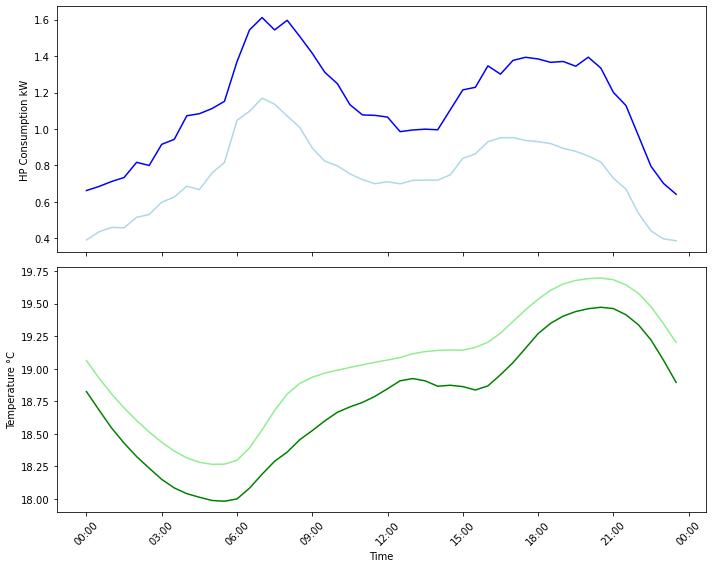

Coldest day and winter average HP Consumption and Internal Air Temperature daily profile separated


In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Your data processing code here...

# Compare mean CD and winter consumption
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(CD_mean_all['Time'], CD_mean_all['delta_HP_Consumption'], color='blue', label='CD HP consumption')
ax1.plot(winter_mean['Time'], winter_mean['delta_HP_Consumption'], color='lightblue', label='WINTER HP consumption')
ax1.set_ylabel('HP Consumption kW')
ax1.tick_params(axis='y')
#ax1.legend(loc='upper left')

ax2.plot(CD_mean_all['Time'], CD_mean_all['Internal_Air_Temperature'], color='green', label='CD indoor temperature')
ax2.plot(winter_mean['Time'], winter_mean['Internal_Air_Temperature'], color='lightgreen', label='WINTER indoor temperature')
ax2.set_ylabel('Temperature °C')
ax2.tick_params(axis='y')
#ax2.legend(loc='upper left')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_xlabel('Time')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print('Coldest day and winter average HP Consumption and Internal Air Temperature daily profile separated')


## Bar graphs showing year and coldest day consumption 

In [58]:
year_consumption_df= pd.read_csv('year_energy_consumption.csv')
CD_consumption_df= pd.read_csv('CD_energy_consumption.csv')
winter_consumption_df = pd.read_csv('winter_energy_consumption.csv')

year_consumption_NoBoiler = year_consumption_df[pd.isnull(year_consumption_df['Boiler_Energy_Output'])]
CD_consumption_NoBoiler = CD_consumption_df[pd.isnull(CD_consumption_df['Boiler_Energy_Output'])]
winter_consumption_df_NoBoiler =winter_consumption_df[pd.isnull(winter_consumption_df['Boiler_Energy_Output'])]

print('Total HP:', len(year_consumption_df)-1, '\nTotal non hybrid HP:' ,len(year_consumption_NoBoiler)-1)

CD_ids_ = CD_consumption_df['Property_ID'].unique().tolist()
winter_ids_ = winter_consumption_df['Property_ID'].unique().tolist()
print(len(winter_ids_), len(CD_ids_))


Total HP: 352 
Total non hybrid HP: 294
353 353


In [59]:
year_mean_WS_cons = year_consumption_NoBoiler['Whole_System_Energy_Consumed'].mean()
year_mean_circ_cons = year_consumption_NoBoiler['Circulation_Pump_Energy_Consumed'].mean()
year_mean_HP_cons = year_consumption_NoBoiler['HP_Consumption'].mean()
year_mean_immers_cons = year_consumption_NoBoiler['Immersion_Heater_Energy_Consumed'].mean()
year_mean_backup_cons = year_consumption_NoBoiler['Back-up_Heater_Energy_Consumed'].mean()

CD_mean_WS_cons = CD_consumption_NoBoiler['Whole_System_Energy_Consumed'].mean()
CD_mean_circ_cons = CD_consumption_NoBoiler['Circulation_Pump_Energy_Consumed'].mean()
CD_mean_HP_cons = CD_consumption_NoBoiler['HP_Consumption'].mean()
CD_mean_immers_cons = CD_consumption_NoBoiler['Immersion_Heater_Energy_Consumed'].mean()
CD_mean_backup_cons = CD_consumption_NoBoiler['Back-up_Heater_Energy_Consumed'].mean()

winter_mean_WS_cons = winter_consumption_df_NoBoiler['Whole_System_Energy_Consumed'].mean()
winter_mean_circ_cons = winter_consumption_df_NoBoiler['Circulation_Pump_Energy_Consumed'].mean()
winter_mean_HP_cons = winter_consumption_df_NoBoiler['HP_Consumption'].mean()
winter_mean_immers_cons = winter_consumption_df_NoBoiler['Immersion_Heater_Energy_Consumed'].mean()
winter_mean_backup_cons = winter_consumption_df_NoBoiler['Back-up_Heater_Energy_Consumed'].mean()


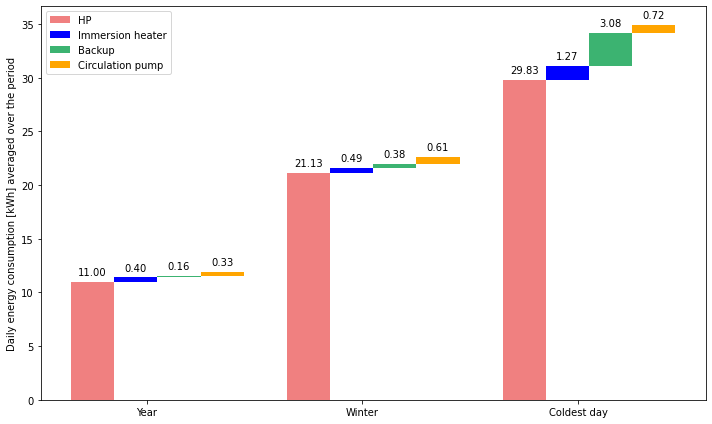

Average daily energy consumption by component for different year, winter, CD cases
winter = 22.61 kWh and CD = 34.87 kWh


In [60]:
x = np.arange(3)
y1 = [year_mean_HP_cons / 365, winter_mean_HP_cons / 90, CD_mean_HP_cons]
y2 = [year_mean_immers_cons / 365, winter_mean_immers_cons / 90, CD_mean_immers_cons]
y3 = [year_mean_backup_cons / 365, winter_mean_backup_cons / 90, CD_mean_backup_cons]
y4 = [year_mean_circ_cons / 365, winter_mean_circ_cons / 90, CD_mean_circ_cons]

bar_width = 0.2
spacing = 0.05
x1 = x - 1.5 * bar_width + spacing
x2 = x - 0.5 * bar_width + spacing
x3 = x + 0.5 * bar_width + spacing
x4 = x + 1.5 * bar_width + spacing

plt.figure(figsize=(10, 6))

plt.bar(x1, y1, width=bar_width, color='lightcoral', label='HP')
plt.bar(x2, y2, width=bar_width, bottom=y1, color='b', label='Immersion heater')
plt.bar(x3, y3, width=bar_width, bottom=[y1[j] + y2[j] for j in range(len(y1))], color='mediumseagreen', label='Backup')
plt.bar(x4, y4, width=bar_width, bottom=[y1[j] + y2[j] + y3[j] for j in range(len(y1))], color='orange', label='Circulation pump')

plt.ylabel('Daily energy consumption [kWh] averaged over the period')
#plt.title('Average daily energy consumption by component for different cases')
plt.legend()

plt.xticks(x, ['Year', 'Winter', 'Coldest day'])

# Add height labels for each stacked bar
for i, (a, b, c, d) in enumerate(zip(y1, y2, y3, y4)):
    plt.text(x1[i], a + 0.9, f'{a:.2f}', ha='center', va='center')
    plt.text(x2[i], a + b + 0.9, f'{b:.2f}', ha='center', va='center')
    plt.text(x3[i], a + b + c + 0.9, f'{c:.2f}', ha='center', va='center')
    plt.text(x4[i], a + b + c + d + 0.9, f'{d:.2f}', ha='center', va='center')

plt.tight_layout()
plt.show()

print('Average daily energy consumption by component for different year, winter, CD cases')
print('winter = 22.61 kWh and CD = 34.87 kWh')

In [61]:
year_consumption_df= pd.read_csv('year_energy_consumption.csv')
CD_consumption_df= pd.read_csv('CD_energy_consumption.csv')
winter_consumption_df = pd.read_csv('winter_energy_consumption.csv')

year_consumption_NoBoiler = year_consumption_df[pd.isnull(year_consumption_df['Boiler_Energy_Output'])]
CD_consumption_NoBoiler = CD_consumption_df[pd.isnull(CD_consumption_df['Boiler_Energy_Output'])]
winter_consumption_df_NoBoiler =winter_consumption_df[pd.isnull(winter_consumption_df['Boiler_Energy_Output'])]

year_consumption_NoBoiler['Imm_+_Backup'] = year_consumption_NoBoiler['Immersion_Heater_Energy_Consumed'].fillna(0) + year_consumption_NoBoiler['Back-up_Heater_Energy_Consumed'].fillna(0)
CD_consumption_NoBoiler['Imm_+_Backup'] = CD_consumption_NoBoiler['Immersion_Heater_Energy_Consumed'].fillna(0) + CD_consumption_NoBoiler['Back-up_Heater_Energy_Consumed'].fillna(0)
winter_consumption_df_NoBoiler['Imm_+_Backup'] = winter_consumption_df_NoBoiler['Immersion_Heater_Energy_Consumed'].fillna(0) + winter_consumption_df_NoBoiler['Back-up_Heater_Energy_Consumed'].fillna(0)

print('Total HP:', len(year_consumption_df), '\nTotal non hybrid HP:' ,len(year_consumption_NoBoiler))

Total HP: 353 
Total non hybrid HP: 295


In [62]:
year_mean_WS_cons = year_consumption_NoBoiler['Whole_System_Energy_Consumed'].mean()
year_mean_HP_cons = year_consumption_NoBoiler['HP_Consumption'].mean()
year_mean_rest = year_mean_WS_cons - year_mean_HP_cons

CD_mean_WS_cons = CD_consumption_NoBoiler['Whole_System_Energy_Consumed'].mean()
CD_mean_HP_cons = CD_consumption_NoBoiler['HP_Consumption'].mean()
CD_mean_rest = CD_mean_WS_cons - CD_mean_HP_cons

winter_mean_WS_cons = winter_consumption_df_NoBoiler['Whole_System_Energy_Consumed'].mean()
winter_mean_HP_cons = winter_consumption_df_NoBoiler['HP_Consumption'].mean()
winter_mean_rest = winter_mean_WS_cons - winter_mean_HP_cons



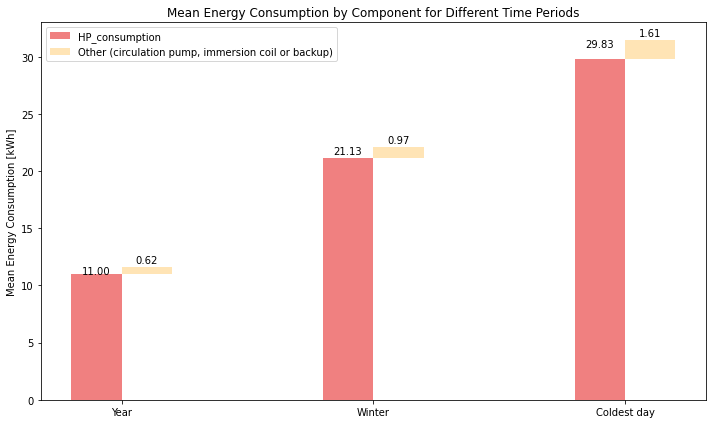

In [63]:
x = np.arange(3)
y1 = [year_mean_HP_cons/365, winter_mean_HP_cons/90, CD_mean_HP_cons] 
y2 = [year_mean_rest/365, winter_mean_rest/90, CD_mean_rest]

bar_width = 0.2
spacing = 0.04  # Adjust the spacing value

x1 = x - 0.4 * bar_width - spacing/2  # Adjust the spacing calculation
x2 = x + 0.4 * bar_width + spacing/2  # Adjust the spacing calculation

plt.figure(figsize=(10, 6))

plt.bar(x1, y1, width=bar_width, color='lightcoral', label='HP_consumption')
plt.bar(x2, y2, width=bar_width, bottom=y1, color='moccasin', label='Other (circulation pump, immersion coil or backup)')

plt.ylabel('Mean Energy Consumption [kWh]')
plt.title('Mean Energy Consumption by Component for Different Time Periods')
plt.xticks(x, ['Year', 'Winter', 'Coldest day'])
plt.legend()

# Add value labels on top of each stacked bar
for i, (a, b) in enumerate(zip(y1, y2)):
    plt.text(x2[i], a + b + 0.2, f'{b:.2f}', ha='center', va='bottom')
    plt.text(x1[i], a + b -0.8, f'{a:.2f}', ha='center', va='bottom')
    

plt.tight_layout()
plt.show()


In [64]:
y_subgroup_with_extra_heating_No_Boiler = year_consumption_NoBoiler[year_consumption_NoBoiler['Imm_+_Backup'] > 0.1]
CD_subgroup_with_extra_heating_No_Boiler = CD_consumption_NoBoiler[CD_consumption_NoBoiler['Imm_+_Backup'] > 0.1]
w_subgroup_with_extra_heating_No_Boiler = winter_consumption_df_NoBoiler[winter_consumption_df_NoBoiler['Imm_+_Backup'] > 0.1]

y_WS_subgroup_mean = y_subgroup_with_extra_heating_No_Boiler['Whole_System_Energy_Consumed'].mean()
y_Circ_subgroup_mean = y_subgroup_with_extra_heating_No_Boiler['Circulation_Pump_Energy_Consumed'].mean()
y_HP_subgroup_mean = y_subgroup_with_extra_heating_No_Boiler['HP_Consumption'].mean()
y_ImmBack_subgroup_mean = y_subgroup_with_extra_heating_No_Boiler['Imm_+_Backup'].mean()

CD_WS_subgroup_mean = CD_subgroup_with_extra_heating_No_Boiler['Whole_System_Energy_Consumed'].mean()
CD_Circ_subgroup_mean = CD_subgroup_with_extra_heating_No_Boiler['Circulation_Pump_Energy_Consumed'].mean()
CD_HP_subgroup_mean = CD_subgroup_with_extra_heating_No_Boiler['HP_Consumption'].mean()
CD_ImmBack_subgroup_mean = CD_subgroup_with_extra_heating_No_Boiler['Imm_+_Backup'].mean()

w_WS_subgroup_mean = w_subgroup_with_extra_heating_No_Boiler['Whole_System_Energy_Consumed'].mean()
w_Circ_subgroup_mean = w_subgroup_with_extra_heating_No_Boiler['Circulation_Pump_Energy_Consumed'].mean()
w_HP_subgroup_mean = w_subgroup_with_extra_heating_No_Boiler['HP_Consumption'].mean()
w_ImmBack_subgroup_mean = w_subgroup_with_extra_heating_No_Boiler['Imm_+_Backup'].mean()

# print(w_WS_subgroup_mean)
# print(w_Circ_subgroup_mean + w_HP_subgroup_mean + w_ImmBack_subgroup_mean)

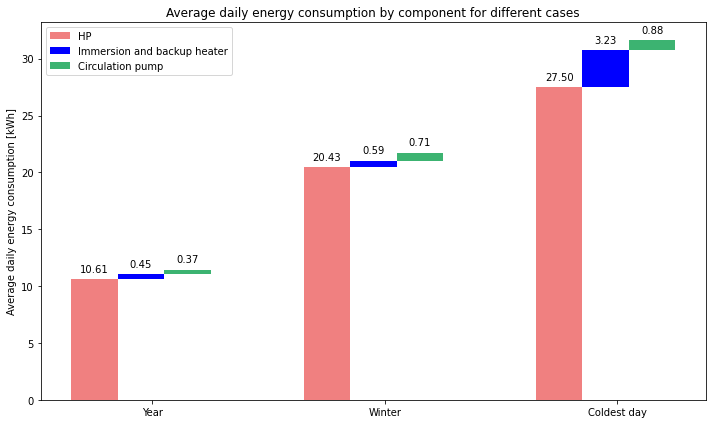

In [65]:
x = np.arange(3)
y1 = [y_HP_subgroup_mean / 365, w_HP_subgroup_mean / 90, CD_HP_subgroup_mean]
y2 = [y_ImmBack_subgroup_mean / 365, w_ImmBack_subgroup_mean / 90, CD_ImmBack_subgroup_mean]
y3 = [y_Circ_subgroup_mean / 365, w_Circ_subgroup_mean / 90, CD_Circ_subgroup_mean]

bar_width = 0.2
spacing = 0.05
x1 = x - 1.5 * bar_width + spacing
x2 = x - 0.5 * bar_width + spacing
x3 = x + 0.5 * bar_width + spacing

plt.figure(figsize=(10, 6))

plt.bar(x1, y1, width=bar_width, color='lightcoral', label='HP')
plt.bar(x2, y2, width=bar_width, bottom=y1, color='b', label='Immersion and backup heater')
plt.bar(x3, y3, width=bar_width, bottom=[y1[j] + y2[j] for j in range(len(y1))], color='mediumseagreen', label='Circulation pump')

plt.ylabel('Average daily energy consumption [kWh]')
plt.title('Average daily energy consumption by component for different cases')
plt.legend()

plt.xticks(x, ['Year', 'Winter', 'Coldest day'])

# Add height labels for each stacked bar
for i, (a, b, c) in enumerate(zip(y1, y2, y3)):
    plt.text(x1[i], a + 0.9, f'{a:.2f}', ha='center', va='center')
    plt.text(x2[i], a + b + 0.9, f'{b:.2f}', ha='center', va='center')
    plt.text(x3[i], a + b + c + 0.9, f'{c:.2f}', ha='center', va='center')

plt.tight_layout()
plt.show()


### Discussion plot comparing CD high, low MCS SHL and average

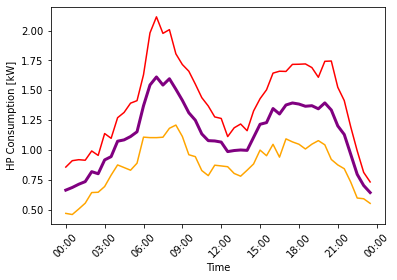

CD Daily HP consumption profiles for low and high MCS SHL houses averaged on the coldest day, and the average CD


In [66]:
fig, ax1 = plt.subplots()

ax1.plot(CD_SHL_low_MCS_df['Time'], CD_SHL_low_MCS_df['delta_HP_Consumption'], color='orange', label='low MCS_SHL HP Consumption')
ax1.plot(CD_SHL_high_MCS_df['Time'], CD_SHL_high_MCS_df['delta_HP_Consumption'], color='red', label='high MCS_SHL HP Consumption')
ax1.plot(CD_mean_all['Time'], CD_mean_all['delta_HP_Consumption'], color='purple', label='CD average HP consumption', linewidth=3)  # Thicker line for average

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('HP Consumption [kW]')
plt.xticks(rotation=45)

lines1, labels1 = ax1.get_legend_handles_labels()

# Uncomment this line if you want to include the legend
#ax1.legend(lines1, labels1)

plt.show()

print('CD Daily HP consumption profiles for low and high MCS SHL houses averaged on the coldest day, and the average CD')


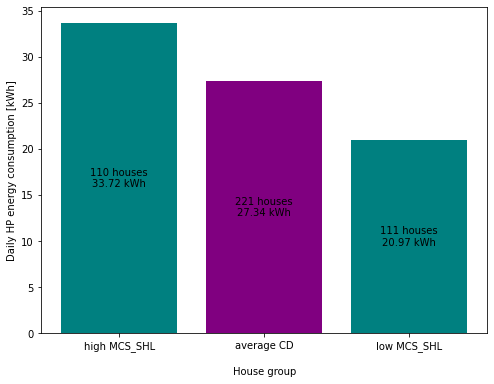

Daily heat pump energy consumption averaged over the coldest day by MCS SHL category and average year


In [67]:
categories = ['high MCS_SHL', 'average CD', 'low MCS_SHL' ]
avg_HP_values = [CD_SHL_highMCS_avg_HP*24, (CD_SHL_highMCS_avg_HP+CD_SHL_lowMCS_avg_HP)*24/2, CD_SHL_lowMCS_avg_HP*24]
unique_property_ids = [len(CD_SHL_high), len(CD_SHL_low)+len(CD_SHL_high), len(CD_SHL_low)]
# unique_property_ids = [num_unique_properties_DEFG, num_unique_properties_ABC, len(CD_SHL_high_MCS_df), len(CD_SHL_low_MCS_df) ]
colors = ['teal', 'purple', 'teal']
plt.figure(figsize=(8, 6))

plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('Daily HP energy consumption [kWh]')
plt.xlabel('\nHouse group')
#plt.title('Daily heat pump power averaged over the year by category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

print('Daily heat pump energy consumption averaged over the coldest day by MCS SHL category and average year')


Daily heat pump energy consumption averaged over the coldest day by MCS SHL category and average year


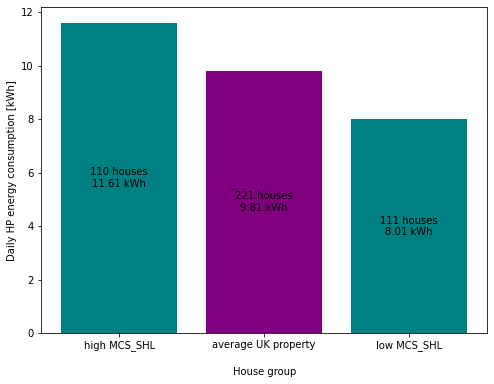

In [68]:
print('Daily heat pump energy consumption averaged over the coldest day by MCS SHL category and average year')

categories = ['high MCS_SHL', 'average UK property', 'low MCS_SHL' ]
avg_HP_values = [ SHL_highMCS_avg_HP*24, 24*(SHL_lowMCS_avg_HP+SHL_highMCS_avg_HP)/2, SHL_lowMCS_avg_HP*24]
unique_property_ids = [ len(SHL_unique_ids_high), len(SHL_unique_ids_high)+ len(SHL_unique_ids_low), len(SHL_unique_ids_low) ]
colors = ['teal', 'purple', 'teal']
plt.figure(figsize=(8, 6))

plt.bar(categories, avg_HP_values, color=colors)
plt.ylabel('Daily HP energy consumption [kWh]')
plt.xlabel('\nHouse group')
#plt.title('Daily heat pump energy consumption averaged over the year by house category')

for i in range(len(categories)):
    #plt.text(i, avg_HP_values[i]/2, f"{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
    plt.text(i, avg_HP_values[i]/2, f"{unique_property_ids[i]} houses\n{avg_HP_values[i]:.2f} kWh", ha='center', va='center')
plt.xticks(rotation=0)
plt.show()

